# **Title:**

## Time-Series Demand Forecasting for E-Commerce Sales using Deep Learning and Tree-Based Models

# **1. Problem Description**
In today’s competitive e-commerce landscape, accurate demand forecasting is crucial for inventory management, supply chain optimization, and marketing strategy. This project focuses on predicting weekly product sales on the Wilberries platform using historical data spanning 2022 to 2024. The dataset includes detailed sales records along with product metadata (e.g., brand, rating, discount).

The goal is to model sales trends and forecast future weekly sales values, thereby enabling the platform to:

*   Anticipate stock needs
*   Optimize promotional campaigns
*   Prevent overstocking or understocking


The core challenge lies in capturing temporal patterns in sales data, which can be influenced by promotions, seasonality, product ratings, and discounts. Additionally, the dataset is high-dimensional with over 330+ features per record and exhibits substantial sparsity, necessitating robust preprocessing and model design.

# **2. Dataset and Preprocessing**

## **Dataset Origin:**
Wilberries.com, an e-commerce platform.
Data Type: Sales data per product per day, along with metadata like seller, brand, rating, and discounts.

## **Preprocessing Steps:**

**Column Translation & Cleaning:** Translated and cleaned over 60+ irrelevant or verbose columns.

**Aggregation:** Daily sales were converted to weekly sales using pd.to_datetime() and resample('W').

**Missing Value Imputation:** Forward-filled missing values, used .fillna(0) for sales.

**Normalization:** MinMaxScaler() was applied for RNN-based models.

**Train-Test Split:** The data from 2022–2023 was used for training, while 2024 was reserved for testing.

# **2.1 Dataset Pre-Processing & Analysis**

## **Library Imports**

In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade tensorflow
!pip install scikit-learn==1.3.2 --quiet
!pip install scikeras --upgrade --quiet

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
  Using cached num

In [2]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import glob

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split

## **Functions for Pre-Processing**



In [3]:
## Functions


columns_to_drop = ['ID склейки','SKU','Промокод', 'СПП', 'Цена СПП', 'Цена с WB кошельком', 'FBS',
                'Subject ID', 'Позиция в категории', 'Страна', 'Ср. % выкупа с возвратами',
                'Средняя позиция в поиске', 'Макс. цена','Мин. цена','Потенциал',
                'Кол-во продаж на отзыв', 'Упущенная выручка','Упущенная выручка %', 'Ссылка', 'Фото',
               'Среднее при наличии','Кол-во фото','3d фото','Дата обнаружения','Дата первого отзыва','Видео',
               'Рейтинг карточки MPSTATS','Средний % выкупа','Кол-во слов в поиске','Видимость карточки','Кол-во рекламных слов в поиске',
                'Кол-во категорий','Средняя позиция в категориях','Кол-во акционных категорий','Кол-во размеров','Кол-во размеров в наличии',
                'Комиссия FBO','Комиссия FBS', 'Процент от выручки топовых товаров в предмете', 'Товары в связке',
               'Товары в связке в наличии','Средняя ставка в поиске','Средняя позиция в рекламных фразах', 'Кол-во складов',
               'Наличие во внешнией рекламе','Средняя позиция в органических фразах','Лучший час в продаж','Лучшая продажа',
                'Кол-во символов в описании','Кол-во символов в названии','Длина упаковки','Ширина упаковки','Высота упаковки','Наличие FBS',
               'Продажи, кол-во','Оборачиваемость','Оборачиваемость дн.','Стоимость замороженного остатка','Замороженный остаток',
                'Видимость в категориях', 'Цвет','Категория','Название','Среднее в день','Средняя дневная выручка', 'Предмет','Процент замороженного остатка',
                'Дней на сайте','Отзывы','Пол','Выручка','Был в наличии','Медиан. цена','Дней с продажами','Медиан. цена','Базовая цена','Средний рейтинг последних отзывов','Рейтинг',
                'Цена','Ср. цена','Наличие, шт.','Кол-во последних отрицательных отзывов в процентах','Цена со скидкой']

def process_data_frame(data):
    # Convert the "Rating" column to float
    if 'Rating' in data.columns:
        data['Rating'] = data['Rating'].astype(str).str.replace(',', '.').astype(float)

    # Convert the "Discounted Price" column to float
    if 'Discounted Price' in data.columns:
        data['Discounted Price'] = data['Discounted Price'].astype(str).str.replace(',', '.').astype(float)

    return data


def translate_columns(df, translations):
    """
    Translates the column names of a DataFrame based on the given translation dictionary.

    :param df: The DataFrame whose columns need to be translated.
    :param translations: A dictionary mapping original column names to their English translations.

    :return: The DataFrame with translated column names.
    """
    df = df.rename(columns=translations)

    # Additional replacements for specific patterns in column names
    if df is not None:
        df = df.rename(columns=lambda name: name.replace('Запросы', 'Requests'))
        df = df.rename(columns=lambda name: name.replace('Продажи', 'Sales'))
        df = df.rename(columns=lambda name: name.replace('Остатки', 'Inventory'))
        df = df.rename(columns=lambda name: name.replace('Выручка', 'Revenue'))

    return df

# Column translation dictionary
column_translations = {
    'Название': 'Name',
    'Категория': 'Category',
    'Бренд': 'Brand',
    'Продавец': 'Seller',
    'Цвет': 'Color',
    'Наличие, шт.': 'Stock, pcs',
    'Отзывы': 'Reviews',
    'Цена': 'Price',
    'Ср. цена': 'Avg Price',
    'Медиан. цена': 'Median Price',
    'Средняя дневная выручка': 'Avg Daily Revenue',
    'Дней на сайте': 'Days on Site',
    'Был в наличии': 'In Stock',
    'Дней с продажами': 'Days with Sales',
    'Рейтинг': 'Rating',
    'Скидка': 'Discount',
    'Цена со скидкой': 'Discounted Price',
    'Среднее в день': 'Avg per Day',
    'Дробный рейтинг': 'Rating',

}

def clean_data(data, columns_to_drop, column_translations):
    """Function to remove unnecessary columns and rename them"""

    # Drop specified columns
    data = data.drop(columns=columns_to_drop, errors='ignore')

    # Rename columns according to the provided map
    data = data.rename(columns=column_translations)

    # Replace parts of column names
    data = data.rename(columns=lambda name: name.replace('Запросы', 'Requests')
                                           .replace('Продажи', 'Sales')
                                           .replace('Остатки', 'Inventory')
                                           .replace('Выручка', 'Revenue'))

    return data



def aggregate_data(data):
    """Function to aggregate the data"""
    # Perform aggregation by Seller
    grouped_data = data.groupby('Seller').agg({
        'Brand': 'first',
        'Discount': 'mean',
        #'Discounted Price': 'mean',
        'Rating': 'mean',
        **{col: 'sum' for col in data.columns if 'Sales' in col},
        **{col: 'sum' for col in data.columns if 'Requests' in col},
        **{col: 'sum' for col in data.columns if 'Inventory' in col},
        **{col: 'sum' for col in data.columns if 'Price' in col},
        **{col: 'sum' for col in data.columns if 'Revenue' in col}
    }).reset_index()

    # Optionally drop columns after aggregation
    keywords = ['Price', 'Inventory', 'Requests', 'Revenue']
    columns_to_drop = [col for col in grouped_data.columns if any(keyword in col for keyword in keywords)]
    grouped_data = grouped_data.drop(columns=columns_to_drop, errors='ignore')

    return grouped_data

def info_data(df):
    """function for outputting basic information about DataFrames"""
    print(f'\n\nNumber of features: {df.shape[1]}, Number of observations: {df.shape[0]}\n')
    print('Let is output the general information about the dataframe:')
    display(df.info())
    print('\nDisplay the first 5 rows:')
    display(df.head(5))
    print('\nDisplay the last 5 rows:')
    display(df.tail(5))
    print('\nCheck for missing values:')
    display(pd.DataFrame(df.isna().mean()*100,).style.background_gradient('BuPu'))
    print(f'\n\nNumber of complete duplicates in the data:')
    display(df.duplicated().sum())
    print('\n\nDescriptive statistics:')
    display(df.describe())

    num_cols, cat_cols = [], []
    for num, i in enumerate(df.columns):
        if pd.api.types.is_numeric_dtype(df[i]):
            print(f'{num+1}) {i} numerical), original values: {len(df[i].unique())}')
            num_cols.append(i)
        elif pd.api.types.is_object_dtype(df[i]):
            print(f'{num+1}) {i} (categorical), original values: {len(df[i].unique())}')
            cat_cols.append(i)
    print(f'\nTotal:\nnumerical: {len(num_cols)}\ncategorical: {len(cat_cols)}')

## **2022**

## **Datasets 2022**

In [4]:
data_02_2022 = pd.read_csv('sales_02_2022.csv', sep=';')
data_03_2022 = pd.read_csv('sales_03_2022.csv', sep=';')
data_04_2022 = pd.read_csv('sales_04_2022.csv', sep=';')
data_05_2022 = pd.read_csv('sales_05_2022.csv', sep=';')
data_06_2022 = pd.read_csv('sales_06_2022.csv', sep=';')
data_07_2022 = pd.read_csv('sales_07_2022.csv', sep=';')
data_08_2022 = pd.read_csv('sales_08_2022.csv', sep=';')
data_09_2022 = pd.read_csv('sales_09_2022.csv', sep=';')
data_10_2022 = pd.read_csv('sales_10_2022.csv', sep=';')
data_11_2022 = pd.read_csv('sales_11_2022.csv', sep=';')
data_12_2022 = pd.read_csv('sales_12_2022.csv', sep=';')

<ipython-input-4-f48b7c3403ea>:1: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_02_2022 = pd.read_csv('sales_02_2022.csv', sep=';')
<ipython-input-4-f48b7c3403ea>:2: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_03_2022 = pd.read_csv('sales_03_2022.csv', sep=';')
<ipython-input-4-f48b7c3403ea>:3: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_04_2022 = pd.read_csv('sales_04_2022.csv', sep=';')
<ipython-input-4-f48b7c3403ea>:4: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_05_2022 = pd.read_csv('sales_05_2022.csv', sep=';')
<ipython-input-4-f48b7c3403ea>:5: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_06_2022 = pd.read_csv('sales_06_2022.csv', sep=';')
<ipython-input-

In [5]:
# data_02_2022
# 1 Drop columns
data_02_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_02_2022
data_02_2022 = translate_columns(data_02_2022, column_translations)
# 3 Chacge types
data_02_2022 = process_data_frame(data_02_2022)
# 4 Drop  unnecessary columns and rename them
data_02_2022 = clean_data(data_02_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_02_2022 = aggregate_data(data_02_2022)

# data_03_2022
# 1 Drop columns
data_03_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_03_2022
data_03_2022 = translate_columns(data_03_2022, column_translations)
# 3 Chacge types
data_03_2022 = process_data_frame(data_03_2022)
# 4 Drop  unnecessary columns and rename them
data_03_2022 = clean_data(data_03_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_03_2022 = aggregate_data(data_03_2022)

# data_04_2022
# 1 Drop columns
data_04_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_04_2022
data_04_2022  = translate_columns(data_04_2022, column_translations)
# 3 Chacge types
data_04_2022 = process_data_frame(data_04_2022)
# 4 Drop  unnecessary columns and rename them
data_04_2022 = clean_data(data_04_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_04_2022 = aggregate_data(data_04_2022)


# data_05_2022
# 1 Drop columns
data_05_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_05_2022
data_05_2022 = translate_columns(data_05_2022, column_translations)
# 3 Chacge types
data_05_2022 = process_data_frame(data_05_2022)
# 4 Drop  unnecessary columns and rename them
data_05_2022 = clean_data(data_05_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_05_2022 = aggregate_data(data_05_2022)


# data_06_2022
# 1 Drop columns
data_06_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_06_2022
data_06_2022 = translate_columns(data_06_2022, column_translations)
# 3 Chacge types
data_06_2022 = process_data_frame(data_06_2022)
# 4 Drop  unnecessary columns and rename them
data_06_2022 = clean_data(data_06_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_06_2022 = aggregate_data(data_06_2022)


# data_07_2022
# 1 Drop columns
data_07_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_07_2022
data_07_2022 = translate_columns(data_07_2022, column_translations)
# 3 Chacge types
data_07_2022 = process_data_frame(data_07_2022)
# 4 Drop  unnecessary columns and rename them
data_07_2022 = clean_data(data_07_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_07_2022 = aggregate_data(data_07_2022)


# data_08_2022
# 1 Drop columns
data_08_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_08_2022
data_08_2022 = translate_columns(data_08_2022, column_translations)
# 3 Chacge types
data_08_2022 = process_data_frame(data_08_2022)
# 4 Drop  unnecessary columns and rename them
data_08_2022 = clean_data(data_08_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_08_2022 = aggregate_data(data_08_2022)


# data_09_2022
# 1 Drop columns
data_09_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_09_2022
data_09_2022  = translate_columns(data_09_2022, column_translations)
# 3 Chacge types
data_09_2022  = process_data_frame(data_09_2022)
# 4 Drop  unnecessary columns and rename them
data_09_2022 = clean_data(data_09_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_09_2022 = aggregate_data(data_09_2022)


# data_10_2022
# 1 Drop columns
data_10_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_10_2022
data_10_2022 = translate_columns(data_10_2022, column_translations)
# 3 Chacge types
data_10_2022 = process_data_frame(data_10_2022)
# 4 Drop  unnecessary columns and rename them
data_10_2022 = clean_data(data_10_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_10_2022 = aggregate_data(data_10_2022)


# data_11_2022
# 1 Drop columns
data_11_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_11_2022
data_11_2022 = translate_columns(data_11_2022, column_translations)
# 3 Chacge types
data_11_2022 = process_data_frame(data_11_2022)
# 4 Drop  unnecessary columns and rename them
data_11_2022 = clean_data(data_11_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_11_2022 = aggregate_data(data_11_2022)


# data_12_2022
# 1 Drop columns
data_12_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_12_2022
data_12_2022 = translate_columns(data_12_2022, column_translations)
# 3 Chacge types
data_12_2022 = process_data_frame(data_12_2022)
# 4 Drop  unnecessary columns and rename them
data_12_2022 = clean_data(data_12_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_12_2022 = aggregate_data(data_12_2022)
data_12_2022


Seller        Brand   Discount    Rating  \
0                            000   ELENS KIDS  53.000000  5.000000   
1                         99 clo       99 clo  28.000000  0.000000   
2                       A-Market       ALIART  24.000000  5.000000   
3                        Afrodia      AFRODIA  49.166667  0.000000   
4                           Alza   ALZA SHOES  75.307692  4.400000   
..                           ...          ...        ...       ...   
789  Цуканов Даниил Владимирович       TDWear  31.000000  0.000000   
790               ЧП Амазонпрайм  FRI&DAYTIME  50.000000  0.000000   
791      Юрий Евгеньевич Корнеев    EuroStyle  43.000000  4.233333   
792        Юрина София Мукимовна    Ariana R.  83.700000  4.500000   
793    Юсифов Тахир Алакбер Оглы     KaranFil  28.000000  0.000000   

     01.12.2022 Sales  02.12.2022 Sales  03.12.2022 Sales  04.12.2022 Sales  \
0                   0                 0                 0                 0   
1                   0                 0                 0                 0   
2                   0                 0                 0                 0   
3                   3                 0                 0                 2   
4                  13                29                23                13   
..                ...               ...               ...               ...   
789                 0                 0                 0                 0   
790                 0                 0                 0                 0   
791                 1                 2                 5                 0   
792                21                21                48                22   
793                 0                 0                 0                 0   

     05.12.2022 Sales  06.12.2022 Sales  ...  22.12.2022 Sales  \
0                   0                 0  ...                 0   
1                   0                 0  ...                 0   
2                   0                 0  ...                 3   
3                   0                 0  ...                 1   
4                  13                 3  ...                29   
..                ...               ...  ...               ...   
789                 0                 0  ...                 0   
790                 0                 0  ...                 0   
791                 1                 4  ...                 0   
792                 6                23  ...                35   
793                 0                 0  ...                 0   

     23.12.2022 Sales  24.12.2022 Sales  25.12.2022 Sales  26.12.2022 Sales  \
0                   0                 0                 0                 0   
1                   0                 0                 0                 0   
2                   3                 0                 0                 0   
3                   1                 0                 0                 0   
4                   9                13                13                19   
..                ...               ...               ...               ...   
789                 0                 0                 0                 0   
790                 0                 0                 0                 0   
791                 1                 1                 0                 0   
792                 7                26                18                18   
793                 0                 1                 0                 0   

     27.12.2022 Sales  28.12.2022 Sales  29.12.2022 Sales  30.12.2022 Sales  \
0                   0                 0                 0                 0   
1                   0                 0                 0                 0   
2                   0                 0                 0                 0   
3                   0                 0                 0                 0   
4                   7                 7                 7                 6   
..                ..

## **Combined dataset 2022**

In [6]:
# Gather all monthly DataFrames into a list
dataframes = [
    data_02_2022, data_03_2022, data_04_2022,
    data_05_2022, data_06_2022, data_07_2022, data_08_2022,
    data_09_2022, data_10_2022, data_11_2022, data_12_2022
]

# Concatenate all DataFrames into one
combined_data = pd.concat(dataframes, ignore_index=True)

# Attempt to cast all columns containing 'Sales' in their name to integers
sales_columns = [col for col in combined_data.columns if 'Sales' in col]
for col in sales_columns:
    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0).astype(int)

# Compute averages and first entries, ensuring float formatting for 'Discount' and 'Rating'
data_2022_all = combined_data.groupby(['Seller', 'Brand'], as_index=False).agg({
    'Discount': 'mean',
    'Rating': 'mean',
    **{col: 'first' for col in sales_columns}
})

# Format 'Discount' and 'Rating' to one decimal place
data_2022_all['Discount'] = data_2022_all['Discount'].round(1)
data_2022_all['Rating'] = data_2022_all['Rating'].round(1)


In [7]:
# Rename columns that contain 'Sales' — keep only the date
new_columns = []
for col in data_2022_all.columns:
    if 'Sales' in col:
        date_str = col.split()[0]
        try:
            date_obj = pd.to_datetime(date_str, format='%d.%m.%Y')
            new_columns.append(date_obj.strftime('%Y-%m-%d'))  # keep only the date in YYYY-MM-DD format
        except:
            new_columns.append(col)
    else:
        new_columns.append(col)

data_2022_all.columns = new_columns


In [8]:
data_2022_all.head(30)

Seller            Brand  Discount  Rating  2022-02-01  \
0                        000       ELENS KIDS      43.1     5.0           0   
1                     99 clo           99 clo      14.0     0.0           0   
2                   A-Market           ALIART      22.0     2.5           0   
3                    Afrodia          AFRODIA      47.9     0.0           0   
4                       Alza       ALZA SHOES      66.4     2.2           0   
5                   Aqustino         AQUSTINO      41.5     1.3           0   
6               Astana Shoes            KEDDO       4.6     0.0           0   
7          Badalli ECO Shoes          Badalli      52.8     2.0           0   
8              Badalli Shoes          Badalli      60.2     2.0           0   
9                    Bilkans          Bilkans      22.3     0.0           0   
10                     Bowlo            FINIK      41.2     2.4           0   
11                   Buluggi          Buluggi      49.9     2.0           0   
12     Choise OF Fashionista             Rabo      65.0     1.5           0   
13                 City Look        CITY LOOK      60.9     3.7           0   
14           Clothes TO Wear  CLOTHES TO WEAR      39.2     0.8           0   
15                    Damlaa           DAMLAA      59.3     0.0           0   
16                Deny-Shoes       Deny-Shoes      56.3     4.7           0   
17                 Elturmoda        ELTURMODA      41.9     1.2           0   
18                Fashionera       Fashionera      25.0     4.4           0   
19                Gold Heels       GOLD HEELS      79.6     4.3           0   
20           Gold Mak-Retail            Benua       5.0     0.0           0   
21                     Heets          SAIJUN.      76.3     3.4           0   
22  Kou Hale Official Market         Kou Hale      35.0     2.0           0   
23                 Laffinely         Caronoir      71.0     4.4           0   
24                 Laffinely        Laffinely      81.0     3.5           0   
25                    Levele       BROSS.SHOP      35.0     1.9           0   
26                   Lunshop          LUNSHOP      75.7     0.0           0   
27                  Matmazel         Matmazel      54.6     2.1           0   
28                Miss Power       MISS POWER      49.7     3.1           0   
29                   Modreal          ModReal      66.3     0.0           0   

    2022-02-02  2022-02-03  2022-02-04  2022-02-05  2022-02-06  ...  \
0            0           0           0           0           0  ...   
1            0           0           0           0           0  ...   
2            0           0           0           0           0  ...   
3            0           0           0           0           0  ...   
4            0           0           0           0           0  ...   
5            0           0           0           0           0  ...   
6            0           0           0           0           0  ...   
7            0           0           0           0           0  ...   
8            0           0           0           0           0  ...   
9            0           0           0           0           0  ...   
10           0           0           0           0           0  ...   
11           0           0           0           0           0  ...   
12           0           0           0           0           0  ...   
13           0           0           0           0           0  ...   
14           0           0           0           0           0  ...   
15           0           0           0           0           0  ...   
16           0           0           0           0           0  ...   
17           0           0           0           0           0  ...   
18           0           0           0           0           0  ...   
19           0           0           0           0           0  ...   
20           0           0           0           0           0  ...   
21        

### **Save a combined `final_data_2022.csv` into one folder**

In [9]:
output_filename = "final_data_2022.csv"

try:
    data_2022_all.to_csv(output_filename, index=False)
    print(f"File saved successfully as: {output_filename}")
except Exception as e:
    print(f"Error while saving the file: {e}")


File saved successfully as: final_data_2022.csv


## **Clean final_dataset 2022**








In [10]:
final_data_2022 = pd.read_csv('final_data_2022.csv')
final_data_2022

Seller            Brand  Discount  Rating  \
0                           000       ELENS KIDS      43.1     5.0   
1                        99 clo           99 clo      14.0     0.0   
2                      A-Market           ALIART      22.0     2.5   
3                       Afrodia          AFRODIA      47.9     0.0   
4                          Alza       ALZA SHOES      66.4     2.2   
...                         ...              ...       ...     ...   
1153      Юрина София Мукимовна        Ariana R.      78.7     2.3   
1154      Юрина София Мукимовна            RI&MI      70.0     4.6   
1155  Юсифов Тахир Алакбер Оглы         KaranFil      46.5     2.3   
1156   Юсупова Раисат Ахмедовна  SAIJUN ORIGINAL      72.5     4.5   
1157   Юсупова Раисат Ахмедовна         SJ STYLE      70.8     4.5   

      2022-02-01  2022-02-02  2022-02-03  2022-02-04  2022-02-05  2022-02-06  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           0   
2              0           0           0           0           0           0   
3              0           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
1153           0           0           0           0           0           0   
1154           0           0           0           0           0           0   
1155           0           0           0           0           0           0   
1156           0           0           0           0           0           0   
1157           0           1           0           0           0           0   

      ...  2022-12-22  2022-12-23  2022-12-24  2022-12-25  2022-12-26  \
0     ...           0           0           0           0           0   
1     ...           0           0           0           0           0   
2     ...           0           0           0           0           0   
3     ...           0           0           0           0           0   
4     ...           0           0           0           0           0   
...   ...         ...         ...         ...         ...         ...   
1153  ...           0           0           0           0           0   
1154  ...           0           0           0           0           0   
1155  ...           0           0           0           0           0   
1156  ...           0           0           0           0           0   
1157  ...           0           0           0           0           0   

      2022-12-27  2022-12-28  2022-12-29  2022-12-30  2022-12-31  
0              0           0           0           0           0  
1              0           0           0           0           0  
2              0           0           0           0           0  
3              0           0           0           0           0  
4              0           0           0           0           0  
...          ...         ...         ...         ...         ...  
1153           0           0           0           0           0  
1154           0           0           0           0           0  
1155           0           0           0           0           0  
1156           0           0           0           0           0  
1157           0           0           0           0           0  

[1158 rows x 338 columns]

In [11]:
info_data(final_data_2022)



Number of features: 338, Number of observations: 1158

Let is output the general information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158 entries, 0 to 1157
Columns: 338 entries, Seller to 2022-12-31
dtypes: float64(2), int64(334), object(2)
memory usage: 3.0+ MB


None


Display the first 5 rows:


Seller       Brand  Discount  Rating  2022-02-01  2022-02-02  2022-02-03  \
0       000  ELENS KIDS      43.1     5.0           0           0           0   
1    99 clo      99 clo      14.0     0.0           0           0           0   
2  A-Market      ALIART      22.0     2.5           0           0           0   
3   Afrodia     AFRODIA      47.9     0.0           0           0           0   
4      Alza  ALZA SHOES      66.4     2.2           0           0           0   

   2022-02-04  2022-02-05  2022-02-06  ...  2022-12-22  2022-12-23  \
0           0           0           0  ...           0           0   
1           0           0           0  ...           0           0   
2           0           0           0  ...           0           0   
3           0           0           0  ...           0           0   
4           0           0           0  ...           0           0   

   2022-12-24  2022-12-25  2022-12-26  2022-12-27  2022-12-28  2022-12-29  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   2022-12-30  2022-12-31  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 338 columns]


Display the last 5 rows:


Seller            Brand  Discount  Rating  \
1153      Юрина София Мукимовна        Ariana R.      78.7     2.3   
1154      Юрина София Мукимовна            RI&MI      70.0     4.6   
1155  Юсифов Тахир Алакбер Оглы         KaranFil      46.5     2.3   
1156   Юсупова Раисат Ахмедовна  SAIJUN ORIGINAL      72.5     4.5   
1157   Юсупова Раисат Ахмедовна         SJ STYLE      70.8     4.5   

      2022-02-01  2022-02-02  2022-02-03  2022-02-04  2022-02-05  2022-02-06  \
1153           0           0           0           0           0           0   
1154           0           0           0           0           0           0   
1155           0           0           0           0           0           0   
1156           0           0           0           0           0           0   
1157           0           1           0           0           0           0   

      ...  2022-12-22  2022-12-23  2022-12-24  2022-12-25  2022-12-26  \
1153  ...           0           0           0           0           0   
1154  ...           0           0           0           0           0   
1155  ...           0           0           0           0           0   
1156  ...           0           0           0           0           0   
1157  ...           0           0           0           0           0   

      2022-12-27  2022-12-28  2022-12-29  2022-12-30  2022-12-31  
1153           0           0           0           0           0  
1154           0           0           0           0           0  
1155           0           0           0           0           0  
1156           0           0           0           0           0  
1157           0           0           0           0           0  

[5 rows x 338 columns]


Check for missing values:




Number of complete duplicates in the data:


np.int64(0)



Descriptive statistics:


Discount       Rating   2022-02-01   2022-02-02   2022-02-03  \
count  1158.000000  1158.000000  1158.000000  1158.000000  1158.000000   
mean     47.241192     2.307945     0.881693     0.889465     0.947323   
std      21.484564     1.692044     5.551736     5.319186     5.717174   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      35.000000     0.400000     0.000000     0.000000     0.000000   
50%      50.450000     2.500000     0.000000     0.000000     0.000000   
75%      63.000000     3.900000     0.000000     0.000000     0.000000   
max      94.000000     5.000000    91.000000    84.000000   106.000000   

        2022-02-04   2022-02-05   2022-02-06   2022-02-07   2022-02-08  ...  \
count  1158.000000  1158.000000  1158.000000  1158.000000  1158.000000  ...   
mean      0.667530     0.856649     0.666667     0.518998     0.995682  ...   
std       4.586346     5.388470     4.962551     3.680531     6.004966  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max      68.000000    94.000000    87.000000    58.000000   112.000000  ...   

        2022-12-22   2022-12-23   2022-12-24   2022-12-25   2022-12-26  \
count  1158.000000  1158.000000  1158.000000  1158.000000  1158.000000   
mean      0.507772     0.158895     0.198618     0.139896     0.192573   
std       6.680732     2.107066     2.218083     1.855017     2.635450   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     149.000000    62.000000    63.000000    56.000000    77.000000   

        2022-12-27   2022-12-28   2022-12-29   2022-12-30   2022-12-31  
count  1158.000000  1158.000000  1158.000000  1158.000000  1158.000000  
mean      0.164940     0.146805     0.224525     0.148532     0.101036  
std       2.416719     2.087342     2.231546     1.868275     1.412740  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max      77.000000    63.000000    57.000000    46.000000    41.000000  

[8 rows x 336 columns]

1) Seller (categorical), original values: 1046
2) Brand (categorical), original values: 934
3) Discount numerical), original values: 514
4) Rating numerical), original values: 51
5) 2022-02-01 numerical), original values: 24
6) 2022-02-02 numerical), original values: 27
7) 2022-02-03 numerical), original values: 29
8) 2022-02-04 numerical), original values: 25
9) 2022-02-05 numerical), original values: 28
10) 2022-02-06 numerical), original values: 22
11) 2022-02-07 numerical), original values: 21
12) 2022-02-08 numerical), original values: 27
13) 2022-02-09 numerical), original values: 20
14) 2022-02-10 numerical), original values: 20
15) 2022-02-11 numerical), original values: 23
16) 2022-02-12 numerical), original values: 28
17) 2022-02-13 numerical), original values: 22
18) 2022-02-14 numerical), original values: 21
19) 2022-02-15 numerical), original values: 16
20) 2022-02-16 numerical), original values: 26
21) 2022-02-17 numerical), original values: 22
22) 2022-02-18 numerical), 

### **Total sales 2022**

To add a "Total_sales" row that aggregates and summarizes data from previous records in a table

In [12]:
# 1. Select only the date columns (formatted as YYYY-MM-DD)
date_columns = final_data_2022.columns[final_data_2022.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate total sales per day (sum across sellers)
daily_sales = final_data_2022[date_columns].sum()

# 3. Calculate total sales for the entire period
total_sales = daily_sales.sum()

# 4. Calculate average rating (excluding zeros)
mean_rating = final_data_2022['Rating'][final_data_2022['Rating'] > 0].mean()

# 5. Calculate average discount (excluding zeros)
mean_discount = final_data_2022['Discount'][final_data_2022['Discount'] > 0].mean()

# Output
print("Total sales by day:")
print(daily_sales)

print(f"\nTotal sales for the entire period: {total_sales}")
print(f"Average rating (excluding zeros): {mean_rating:.2f}")
print(f"Average discount (excluding zeros): {mean_discount:.2f}")




Total sales by day:
2022-02-01    1021
2022-02-02    1030
2022-02-03    1097
2022-02-04     773
2022-02-05     992
              ... 
2022-12-27     191
2022-12-28     170
2022-12-29     260
2022-12-30     172
2022-12-31     117
Length: 334, dtype: int64

Total sales for the entire period: 64727
Average rating (excluding zeros): 3.03
Average discount (excluding zeros): 49.91


### **Plot: Daily sales**



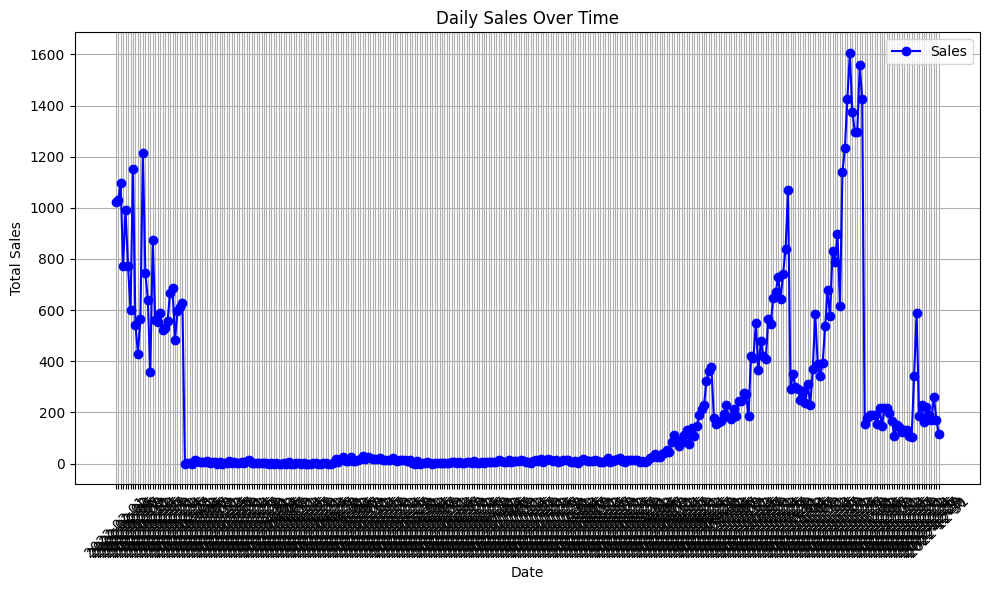

In [13]:
#Plot a line chart of daily sales
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-', color='b', label='Sales')

plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


### **Weekly sales**

In [14]:
# Step 1: Identify date columns
date_columns = final_data_2022.columns[final_data_2022.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# Step 2: Reshape the DataFrame to long format
df_long = final_data_2022.melt(
    id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
    value_vars=date_columns,
    var_name='Date',
    value_name='Sales'
)

# Step 3: Convert and prepare data
df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce').fillna(0).astype(int)
df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['WeekStart'] = df_long['Date'] - pd.to_timedelta(df_long['Date'].dt.dayofweek, unit='days')
df_long['WeekEnd'] = df_long['WeekStart'] + pd.Timedelta(days=6)
df_long['WeekRange'] = df_long['WeekStart'].dt.strftime('%Y-%m-%d') + ' to ' + df_long['WeekEnd'].dt.strftime('%Y-%m-%d')

# Step 4: Group sales by week, seller, and brand
weekly_sales = df_long.groupby(['Seller', 'Brand', 'WeekRange'], as_index=False)['Sales'].sum()

# Step 5: Pivot the data so each week range becomes a separate column
final_data_2022_weekly = weekly_sales.pivot(
    index=['Seller', 'Brand'],
    columns='WeekRange',
    values='Sales'
).fillna(0).astype(int).reset_index()

# Step 6: Restore Discount and Rating columns by merging from original dataset
meta_info = final_data_2022[['Seller', 'Brand', 'Discount', 'Rating']].drop_duplicates()
final_data_2022_weekly = final_data_2022_weekly.merge(meta_info, on=['Seller', 'Brand'], how='left')

# Step 7: Reorder columns for readability
cols = ['Seller', 'Brand', 'Discount', 'Rating'] + [col for col in final_data_2022_weekly.columns if col not in ['Seller', 'Brand', 'Discount', 'Rating']]
final_data_2022_weekly = final_data_2022_weekly[cols]

# Resulting DataFrame is ready
final_data_2022_weekly


Seller            Brand  Discount  Rating  \
0                           000       ELENS KIDS      43.1     5.0   
1                        99 clo           99 clo      14.0     0.0   
2                      A-Market           ALIART      22.0     2.5   
3                       Afrodia          AFRODIA      47.9     0.0   
4                          Alza       ALZA SHOES      66.4     2.2   
...                         ...              ...       ...     ...   
1153      Юрина София Мукимовна        Ariana R.      78.7     2.3   
1154      Юрина София Мукимовна            RI&MI      70.0     4.6   
1155  Юсифов Тахир Алакбер Оглы         KaranFil      46.5     2.3   
1156   Юсупова Раисат Ахмедовна  SAIJUN ORIGINAL      72.5     4.5   
1157   Юсупова Раисат Ахмедовна         SJ STYLE      70.8     4.5   

      2022-01-31 to 2022-02-06  2022-02-07 to 2022-02-13  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
1153                         0                         0   
1154                         0                         0   
1155                         0                         0   
1156                         0                         0   
1157                         1                         2   

      2022-02-14 to 2022-02-20  2022-02-21 to 2022-02-27  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
1153                         0                         0   
1154                         0                         0   
1155                         0                         0   
1156                         0                         0   
1157                         3                         1   

      2022-02-28 to 2022-03-06  2022-03-07 to 2022-03-13  ...  \
0                            0                         0  ...   
1                            0                         0  ...   
2                            0                         0  ...   
3                            0                         0  ...   
4                            0                         0  ...   
...                        ...                       ...  ...   
1153                         0                         0  ...   
1154                         0                         0  ...   
1155                         0                         0  ...   
1156                         0                         0  ...   
1157                         0                         0  ...   

      2022-10-24 to 2022-10-30  2022-10-31 to 2022-11-06  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                           23                         0   
...                        ...                       ...   
1153                         0                         0   
1154                         0                         0   
1155                         0                         0   
1156                         0                         0   
1157                         0                         0   

      2022-11-07 to 2022-11-13  2022-11-14 to 2022-11-20  \
0                            0                         0   
1                            0                         0   
2                            0                         0   


In [15]:
print(final_data_2022.columns)

Index(['Seller', 'Brand', 'Discount', 'Rating', '2022-02-01', '2022-02-02',
       '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06',
       ...
       '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
      dtype='object', length=338)


### **Save a combined `final_data_2022_weekly.csv` into one folder**

In [16]:
output_filename = "final_data_2022_weekly.csv"

try:
    final_data_2022_weekly.columns.name = None
    final_data_2022_weekly.to_csv(output_filename, index=False)
    print(f"File saved successfully as: {output_filename}")
except Exception as e:
    print(f"Error while saving the file: {e}")

File saved successfully as: final_data_2022_weekly.csv


### **PlotPlot: weekly sales 2022 of sellers**

<ipython-input-17-014cb09cd90d>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


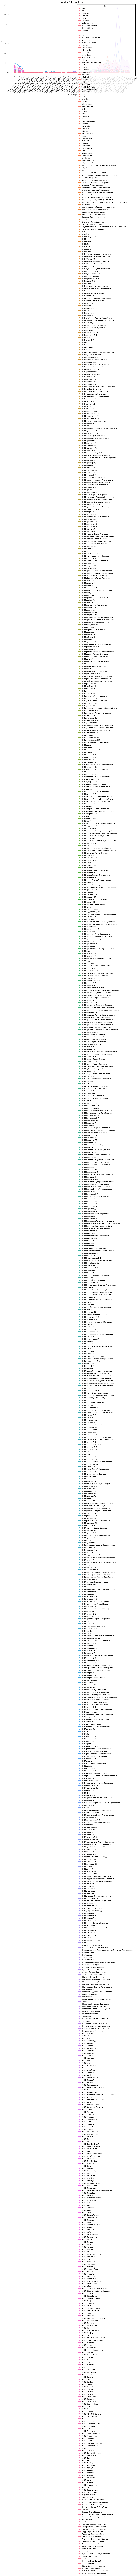

In [17]:
# First, prepare the data for visualization
# `weekly_sales` should contain all the information in a long format for easier plotting
# Assuming you continue from previous code:
# `weekly_sales`: DataFrame after grouping and summation

# Create the plot
plt.figure(figsize=(14, 8))

# Sort the weekly range for proper display on the plot
weekly_sales['WeekRange'] = pd.Categorical(weekly_sales['WeekRange'], ordered=True, categories=sorted(weekly_sales['WeekRange'].unique()))

# Plot a line graph for each seller
sns.lineplot(data=weekly_sales, x='WeekRange', y='Sales', hue='Seller', marker='o')

# Adjust the plot settings for better readability
plt.xticks(rotation=45)  # Rotate the weekly range labels
plt.title('Weekly Sales by Seller')
plt.xlabel('Week Range')
plt.ylabel('Sales')
plt.legend(title='Seller')
plt.tight_layout()

# Display the plot
plt.show()


### **Plot: total weekly sales 2022**

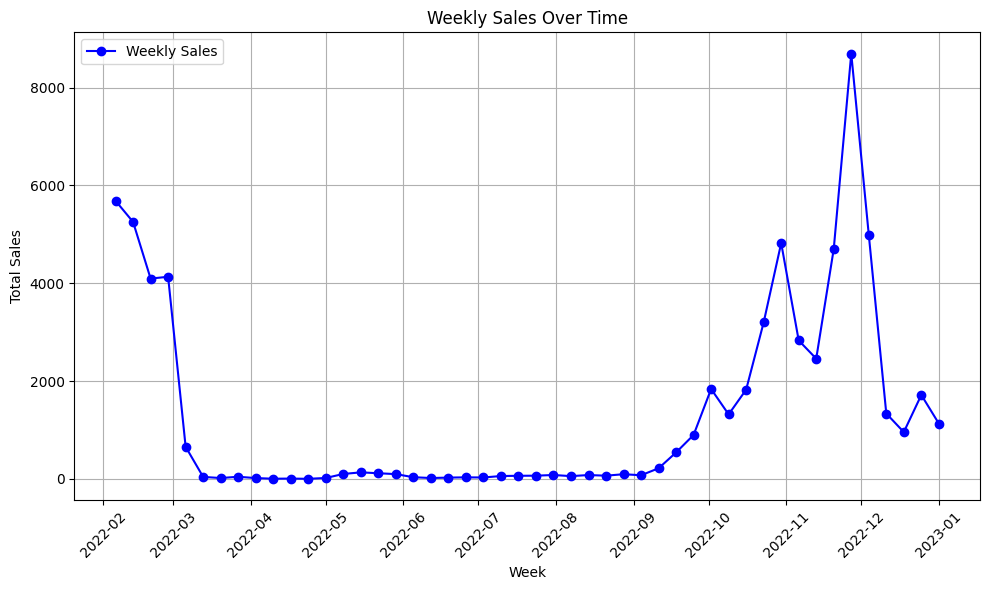

In [18]:
# 1. Select columns with dates in YYYY-MM-DD format
date_columns = final_data_2022.columns[final_data_2022.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate daily sales
daily_sales = final_data_2022[date_columns].sum()

# Convert index to a datetime format
daily_sales.index = pd.to_datetime(daily_sales.index)

# 3. Group data by week and calculate weekly total sales
weekly_sales = daily_sales.resample('W').sum()

# 4. Plot the weekly sales graph
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-', color='b', label='Weekly Sales')

plt.title('Weekly Sales Over Time')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()

# Display the plot
plt.show()



## **2023**

## **Datasets 2023**

In [19]:
data_01_2023 = pd.read_csv('./sales_01_2023.csv', sep=';')
data_02_2023 = pd.read_csv('./sales_02_2023.csv', sep=';')
data_03_2023 = pd.read_csv('./sales_03_2023.csv', sep=';')
data_04_2023 = pd.read_csv('./sales_04_2023.csv', sep=';')
data_05_2023 = pd.read_csv('./sales_05_2023.csv', sep=';')
data_06_2023 = pd.read_csv('./sales_06_2023.csv', sep=';')
data_07_2023 = pd.read_csv('./sales_07_2023.csv', sep=';')
data_08_2023 = pd.read_csv('./sales_08_2023.csv', sep=';')
data_09_2023 = pd.read_csv('./sales_09_2023.csv', sep=';')
data_10_2023 = pd.read_csv('./sales_10_2023.csv', sep=';')
data_11_2023 = pd.read_csv('./sales_11_2023.csv', sep=';')
data_12_2023 = pd.read_csv('./sales_12_2023.csv', sep=';')

<ipython-input-19-ad0379dba404>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_01_2023 = pd.read_csv('./sales_01_2023.csv', sep=';')
<ipython-input-19-ad0379dba404>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_03_2023 = pd.read_csv('./sales_03_2023.csv', sep=';')
<ipython-input-19-ad0379dba404>:4: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_04_2023 = pd.read_csv('./sales_04_2023.csv', sep=';')
<ipython-input-19-ad0379dba404>:7: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_07_2023 = pd.read_csv('./sales_07_2023.csv', sep=';')
<ipython-input-19-ad0379dba404>:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_10_2023 = pd.read_csv('./sales_10_2023.csv', sep=';')
<ipython-in

In [20]:
data_12_2023

SKU  ID склейки  \
0        8204398     6370183   
1        8204399     6370183   
2      123422972   110015751   
3      170850672   110015751   
4      123422982   110015751   
...          ...         ...   
22095   50573823    37653700   
22096  198811683   180304190   
22097  194594283   176703167   
22098   47123643    35080857   
22099  179089383   163359627   

                                                Название  \
0                                    Угги зимние высокие   
1                                    Угги зимние высокие   
2                           Угги короткие зимние с мехом   
3      Угги зимние на платформе полусапожки с мехом с...   
4      Угги мини зимние на толстой подошве полусапожк...   
...                                                  ...   
22095                                               Угги   
22096                       Угги зимние короткие с мехом   
22097                            Угги натуральные зимние   
22098                                               Угги   
22099                                               Угги   

                       Категория          Бренд                      Продавец  \
0      Обувь/Женская/Сапоги/Угги     T.TACCARDI                      ООО Кари   
1      Обувь/Женская/Сапоги/Угги     T.TACCARDI                      ООО Кари   
2      Обувь/Женская/Сапоги/Угги   Dolce Gracia    Кудашкина Ольга Васильевна   
3                            NaN   Dolce Gracia    Кудашкина Ольга Васильевна   
4      Обувь/Женская/Сапоги/Угги   Dolce Gracia    Кудашкина Ольга Васильевна   
...                          ...            ...                           ...   
22095                        NaN  LADY MAGNORIA                ООО Обувь Плюс   
22096                        NaN        NeoMoon                      ИП Айзат   
22097                        NaN    FRI&DAYTIME  ИП Повстяной Сергей Олегович   
22098                        NaN  LADY MAGNORIA                ООО Обувь Плюс   
22099                        NaN       Tendance                   ООО Рандеву   

                                                    Цвет  Наличие, шт.  \
0                                                  серый          3998   
1                                                 черный          2745   
2                                          черный графит           482   
3                                              оранжевый            87   
4      терракотовый, рыжий терракот, терракота, терра...           200   
...                                                  ...           ...   
22095                                  синий, золотистый             1   
22096                                                NaN             0   
22097                                         коричневый             0   
22098                                              серый             3   
22099                                                NaN             0   

       Наличие FBS  Отзывы  ...  22.12.2023 Запросы  23.12.2023 Запросы  \
0                0    9394  ...                   0                   0   
1                0    9394  ...                   0                   0   
2                0    6808  ...                   0                   0   
3                0    6808  ...                   0                   0   
4                0    6808  ...                   0                   0   
...            ...     ...  ...                 ...                 ...   
22095            0       0  ...                   0                   0   
22096         5994       0  ...                   0                   0   
22097           10       0  ...                   0                   0   
22098            0       0  ...                   0                   0   
22099            2       0  ...                   0                   0   

       24.12.2023 Запросы 25.12.2023 Запросы 26.12.2023 Запросы  \
0                       0                  0                  0   
1         

In [21]:
# data_01_2023
# 1 Drop columns
data_01_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_01_2023
data_01_2023 = translate_columns(data_01_2023, column_translations)
# 3 Chacge types
data_01_2023 = process_data_frame(data_01_2023)
# 4 Drop  unnecessary columns and rename them
data_01_2023 = clean_data(data_01_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_01_2023 = aggregate_data(data_01_2023)

# data_02_2023
# 1 Drop columns
data_02_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_02_2023
data_02_2023 = translate_columns(data_02_2023, column_translations)
# 3 Chacge types
data_02_2023 = process_data_frame(data_02_2023)
# 4 Drop  unnecessary columns and rename them
data_02_2023 = clean_data(data_02_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_02_2023 = aggregate_data(data_02_2023)

# data_03_2023
# 1 Drop columns
data_03_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_03_2023
data_03_2023 = translate_columns(data_03_2023, column_translations)
# 3 Chacge types
data_03_2023 = process_data_frame(data_03_2023)
# 4 Drop  unnecessary columns and rename them
data_03_2023 = clean_data(data_03_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_03_2023 = aggregate_data(data_03_2023)

# data_04_2023
# 1 Drop columns
data_04_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_04_2023
data_04_2023 = translate_columns(data_04_2023, column_translations)
# 3 Chacge types
data_04_2023 = process_data_frame(data_04_2023)
# 4 Drop  unnecessary columns and rename them
data_04_2023 = clean_data(data_04_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_04_2023 = aggregate_data(data_04_2023)

# data_05_2023
# 1 Drop columns
data_05_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_05_2023
data_05_2023 = translate_columns(data_05_2023, column_translations)
# 3 Chacge types
data_05_2023 = process_data_frame(data_05_2023)
# 4 Drop  unnecessary columns and rename them
data_05_2023 = clean_data(data_05_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_05_2023 = aggregate_data(data_05_2023)

# data_06_2023
# 1 Drop columns
data_06_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_06_2023
data_06_2023 = translate_columns(data_06_2023, column_translations)
# 3 Chacge types
data_06_2023 = process_data_frame(data_06_2023)
# 4 Drop  unnecessary columns and rename them
data_06_2023 = clean_data(data_06_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_06_2023 = aggregate_data(data_06_2023)

# data_07_2023
# 1 Drop columns
data_07_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_07_2023
data_07_2023 = translate_columns(data_07_2023, column_translations)
# 3 Chacge types
data_07_2023 = process_data_frame(data_07_2023)
# 4 Drop  unnecessary columns and rename them
data_07_2023 = clean_data(data_07_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_07_2023 = aggregate_data(data_07_2023)

# data_08_2023
# 1 Drop columns
data_08_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_08_2023
data_08_2023 = translate_columns(data_08_2023, column_translations)
# 3 Chacge types
data_08_2023 = process_data_frame(data_08_2023)
# 4 Drop  unnecessary columns and rename them
data_08_2023 = clean_data(data_08_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_08_2023 = aggregate_data(data_08_2023)

# data_09_2023
# 1 Drop columns
data_09_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_09_2023
data_09_2023 = translate_columns(data_09_2023, column_translations)
# 3 Chacge types
data_09_2023 = process_data_frame(data_09_2023)
# 4 Drop  unnecessary columns and rename them
data_09_2023 = clean_data(data_09_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_09_2023 = aggregate_data(data_09_2023)

# data_10_2023
# 1 Drop columns
data_10_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_10_2023
data_10_2023 = translate_columns(data_10_2023, column_translations)
# 3 Chacge types
data_10_2023 = process_data_frame(data_10_2023)
# 4 Drop  unnecessary columns and rename them
data_10_2023 = clean_data(data_10_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_10_2023 = aggregate_data(data_10_2023)

# data_11_2023
# 1 Drop columns
data_11_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_11_2023
data_11_2023 = translate_columns(data_11_2023, column_translations)
# 3 Chacge types
data_11_2023= process_data_frame(data_11_2023)
# 4 Drop  unnecessary columns and rename them
data_11_2023 = clean_data(data_11_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_11_2023 = aggregate_data(data_11_2023)

# data_12_2023
# 1 Drop columns
data_12_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_12_2023
data_12_2023 = translate_columns(data_12_2023, column_translations)
# 3 Chacge types
data_12_2023 = process_data_frame(data_12_2023)
# 4 Drop  unnecessary columns and rename them
data_12_2023 = clean_data(data_12_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_12_2023 = aggregate_data(data_12_2023)
data_12_2023


Seller       Brand   Discount    Rating  \
0                                ...   E.M-pelle  74.800000  4.520000   
1                            01 Atel     01 atel  64.000000  5.000000   
2                               1220  12/20 SHOP  76.000000  4.700000   
3                             4Lwear      4Lwear  79.380952  5.000000   
4                              4Magz       4MAGZ  67.857143  4.442857   
...                              ...         ...        ...       ...   
1726  Чезганова Екатерина Васильевна       Алиша  79.000000  2.500000   
1727      Чинчик Александр Сергеевич  НосиВкусно  66.000000  4.200000   
1728     Шульгина Гульнара Эскеровна     M.rossy  65.800000  4.600000   
1729         Юрий Евгеньевич Корнеев   EuroStyle  64.000000  4.200000   
1730           Юрина София Мукимовна   Ariana R.  81.600000  3.900000   

      01.12.2023 Sales  02.12.2023 Sales  03.12.2023 Sales  04.12.2023 Sales  \
0                    8                 8                 8                 8   
1                    0                 1                 3                 2   
2                    0                 0                 3                 1   
3                    0                 0                 0                 0   
4                    0                 0                 0                 0   
...                ...               ...               ...               ...   
1726                 0                 2                 0                 1   
1727                 3                 0                 0                 0   
1728                21                23                30                27   
1729                 1                 0                 2                 0   
1730                 3                 7                 6                 8   

      05.12.2023 Sales  06.12.2023 Sales  ...  22.12.2023 Sales  \
0                    1                 4  ...                 1   
1                    1                 1  ...                 0   
2                    2                 1  ...                 0   
3                    0                 0  ...                 1   
4                    0                 0  ...                 0   
...                ...               ...  ...               ...   
1726                 0                 1  ...                 0   
1727                 0                 0  ...                 0   
1728                33                32  ...                 2   
1729                 1                 0  ...                 0   
1730                 5                 4  ...                13   

      23.12.2023 Sales  24.12.2023 Sales  25.12.2023 Sales  26.12.2023 Sales  \
0                    1                 1                 2                 2   
1                    0                 1                 1                 1   
2                    1                 0                 1                 1   
3                    0                 0                 0                 0   
4                    0                 0                 1                 0   
...                ...               ...               ...               ...   
1726                 0                 1                 1                 0   
1727                 0                 0                 0                 0   
1728                 7                 9                17                10   
1729                 0                 0                 0                 0   
1730                13                16                15                11   

      27.12.2023 Sales  28.12.2023 Sales  29.12.2023 Sales  30.12.2023 Sales  \
0                    1                 1                 3                 0   
1                    1                 2                 0                 0   
2                    1                 0                 0                 0   
3                    0                 0                 0                 0   
4                    0    

## **Combined dataset 2023**

In [22]:
# Gather all monthly DataFrames into a list
dataframes = [
    data_01_2023, data_02_2023, data_03_2023, data_04_2023,
    data_05_2023, data_06_2023, data_07_2023, data_08_2023,
    data_09_2023, data_10_2023, data_11_2023, data_12_2023
]

# Concatenate all DataFrames into one
combined_data = pd.concat(dataframes, ignore_index=True)

# Attempt to cast all columns containing 'Sales' in their name to integers
sales_columns = [col for col in combined_data.columns if 'Sales' in col]
for col in sales_columns:
    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0).astype(int)

# Compute averages and first entries, ensuring float formatting for 'Discount' and 'Rating'
data_2023_all = combined_data.groupby(['Seller', 'Brand'], as_index=False).agg({
    'Discount': 'mean',
    'Rating': 'mean',
    **{col: 'first' for col in sales_columns}
})

# Format 'Discount' and 'Rating' to one decimal place
data_2023_all['Discount'] = data_2023_all['Discount'].round(1)
data_2023_all['Rating'] = data_2023_all['Rating'].round(1)

In [23]:
# Rename columns that contain 'Sales' — keep only the date
new_columns = []
for col in data_2023_all.columns:
    if 'Sales' in col:
        date_str = col.split()[0]
        try:
            date_obj = pd.to_datetime(date_str, format='%d.%m.%Y')
            new_columns.append(date_obj.strftime('%Y-%m-%d'))  # keep only the date in YYYY-MM-DD format
        except:
            new_columns.append(col)
    else:
        new_columns.append(col)

data_2023_all.columns = new_columns

In [24]:
data_2023_all.head(30)

Seller            Brand  Discount  Rating  2023-01-01  2023-01-02  \
0           ...        E.M-pelle      72.4     4.6           0           0   
1           ...  Планета Шопинга      69.4     4.1           0           0   
2           000       ELENS KIDS      67.0     5.0           0           0   
3       01 Atel          01 Atel      55.0     5.0           0           0   
4       01 Atel          01 atel      64.0     5.0           0           0   
5          1220       12/20 SHOP      67.7     4.9           0           0   
6        4Lwear           4Lwear      79.4     5.0           0           0   
7         4Magz            4MAGZ      70.4     4.2           0           0   
8        99 clo           99 clo      28.0     0.0           0           1   
9      A-Market           ALIART      54.8     4.0           0           0   
10    AFN Shoes        AFN SHOES      72.0     4.6           0           0   
11          AKB        SOFT STEP      62.0     3.3           0           0   
12          AMB            М.Б.Ф      83.6     4.0           0           0   
13          AMB              МБФ      76.0     3.3           0           0   
14     AMG Shop              UGG      66.3     4.1           0           0   
15      Aciento       PERLA PINA      68.2     4.0           0           0   
16     Advocate         Advocate      69.6     4.7           0           0   
17     Advocate         advocate      58.1     3.4           0           0   
18      Afrodia          AFRODIA      66.3     0.0           0           1   
19        Akram            AKRAM      36.0     5.0           0           0   
20    Al Kausar       Fashion sm      22.3     1.8           0           0   
21       Ali.al           ALI.AL      50.2     4.3           0           0   
22       Ali.al           Ali.Al      38.3     1.3           0           0   
23      Allanor          Allanor      65.5     3.1           0           0   
24  Alternative      ALTERNATIVE      79.6     4.5           0           0   
25  Alternative      Alternative      71.3     4.6           0           0   
26        Amigo       Amigo shop      67.7     2.6           0           0   
27     Aqustino         AQUSTINO      77.7     3.6          12          11   
28       Artfit     угги женские      69.5     4.0           0           0   
29         Aska        As&Ka UGG      39.0     0.0           0           0   

    2023-01-03  2023-01-04  2023-01-05  2023-01-06  ...  2023-12-22  \
0            0           0           0           0  ...           0   
1            0           0           0           0  ...           0   
2            0           0           0           0  ...           0   
3            0           0           0           0  ...           0   
4            0           0           0           0  ...           0   
5            0           0           0           0  ...           0   
6            0           0           0           0  ...           1   
7            0           0           0           0  ...           0   
8            0           0           0           1  ...           0   
9            0           0           0           1  ...           0   
10           0           0           0           0  ...           3   
11           0           0           0           0  ...           0   
12           0           0           0           0  ...           9   
13           0           0           0           0  ...           0   
14           0           0           0           0  ...           0   
15           0           0           0           0  ...           0   
16           0           0           0           0  ...           2   
17           0           0           0           0  ...           0   
18           1           1           0           0  ...           0   
19           0           0           0           0  ...           0   
20           0           0           0           0  ...           0   
21           0           0  

## **Save the combined `final_data_2023.csv` into one folder**

In [25]:
output_filename = "final_data_2023.csv"

try:
    data_2023_all.to_csv(output_filename, index=False)
    print(f"File saved successfully as: {output_filename}")
except Exception as e:
    print(f"Error while saving the file: {e}")

File saved successfully as: final_data_2023.csv


## **Clean final dataset 2023**

In [26]:
final_data_2023 = pd.read_csv('./final_data_2023.csv')
final_data_2023

Seller            Brand  Discount  Rating  \
0                             ...        E.M-pelle      72.4     4.6   
1                             ...  Планета Шопинга      69.4     4.1   
2                             000       ELENS KIDS      67.0     5.0   
3                         01 Atel          01 Atel      55.0     5.0   
4                         01 Atel          01 atel      64.0     5.0   
...                           ...              ...       ...     ...   
2685  Шульгина Гульнара Эскеровна          M.rossy      53.5     3.1   
2686      Юрий Евгеньевич Корнеев        EuroStyle      51.1     4.1   
2687        Юрина София Мукимовна        Ariana R.      84.1     4.4   
2688    Юсифов Тахир Алакбер Оглы         KaranFil      56.0     0.0   
2689     Юсупова Раисат Ахмедовна  SAIJUN ORIGINAL      88.5     4.7   

      2023-01-01  2023-01-02  2023-01-03  2023-01-04  2023-01-05  2023-01-06  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           0   
2              0           0           0           0           0           0   
3              0           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
2685           0           0           0           0           0           0   
2686           0           2           0           0           0           0   
2687           7          15          26          16           7          17   
2688           0           0           0           0           0           0   
2689           0           0           0           0           0           0   

      ...  2023-12-22  2023-12-23  2023-12-24  2023-12-25  2023-12-26  \
0     ...           0           0           0           0           0   
1     ...           0           0           0           0           0   
2     ...           0           0           0           0           0   
3     ...           0           0           0           0           0   
4     ...           0           0           1           1           1   
...   ...         ...         ...         ...         ...         ...   
2685  ...           0           0           0           0           0   
2686  ...           0           0           0           0           0   
2687  ...           0           0           0           0           0   
2688  ...           0           0           0           0           0   
2689  ...           0           0           0           0           0   

      2023-12-27  2023-12-28  2023-12-29  2023-12-30  2023-12-31  
0              0           0           0           0           0  
1              0           0           0           0           0  
2              0           0           0           0           0  
3              0           0           0           0           0  
4              1           2           0           0           0  
...          ...         ...         ...         ...         ...  
2685           0           0           0           0           0  
2686           0           0           0           0           0  
2687           0           0           0           0           0  
2688           0           0           0           0           0  
2689           0           0           0           0           0  

[2690 rows x 369 columns]

### **Total sales 2023**

In [27]:
# 1. Select only the date columns (formatted as YYYY-MM-DD)
date_columns = final_data_2023.columns[final_data_2023.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate total sales per day (sum across sellers)
daily_sales = final_data_2023[date_columns].sum()

# 3. Calculate total sales for the entire period
total_sales = daily_sales.sum()

# 4. Calculate average rating (excluding zeros)
mean_rating = final_data_2023['Rating'][final_data_2023['Rating'] > 0].mean()

# 5. Calculate average discount (excluding zeros)
mean_discount = final_data_2023['Discount'][final_data_2023['Discount'] > 0].mean()

# Output
print("Total sales by day:")
print(daily_sales)

print(f"\nTotal sales for the entire period: {total_sales}")
print(f"Average rating (excluding zeros): {mean_rating:.2f}")
print(f"Average discount (excluding zeros): {mean_discount:.2f}")

Total sales by day:
2023-01-01    1927
2023-01-02    3158
2023-01-03    3324
2023-01-04    3993
2023-01-05    3949
              ... 
2023-12-27    1203
2023-12-28    1190
2023-12-29    1120
2023-12-30     868
2023-12-31     725
Length: 365, dtype: int64

Total sales for the entire period: 300167
Average rating (excluding zeros): 3.75
Average discount (excluding zeros): 57.54


### **Weekly sales**

In [28]:
# Step 1: Identify date columns
date_columns = final_data_2023.columns[final_data_2023.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# Step 2: Reshape the DataFrame to long format
df_long = final_data_2023.melt(
    id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
    value_vars=date_columns,
    var_name='Date',
    value_name='Sales'
)

# Step 3: Convert and prepare data
df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce').fillna(0).astype(int)
df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['WeekStart'] = df_long['Date'] - pd.to_timedelta(df_long['Date'].dt.dayofweek, unit='days')
df_long['WeekEnd'] = df_long['WeekStart'] + pd.Timedelta(days=6)
df_long['WeekRange'] = df_long['WeekStart'].dt.strftime('%Y-%m-%d') + ' to ' + df_long['WeekEnd'].dt.strftime('%Y-%m-%d')

# Step 4: Group sales by week, seller, and brand
weekly_sales = df_long.groupby(['Seller', 'Brand', 'WeekRange'], as_index=False)['Sales'].sum()

# Step 5: Pivot the data so each week range becomes a separate column
final_data_2023_weekly = weekly_sales.pivot(
    index=['Seller', 'Brand'],
    columns='WeekRange',
    values='Sales'
).fillna(0).astype(int).reset_index()

# Step 6: Restore Discount and Rating columns by merging from original dataset
meta_info = final_data_2023[['Seller', 'Brand', 'Discount', 'Rating']].drop_duplicates()
final_data_2023_weekly = final_data_2023_weekly.merge(meta_info, on=['Seller', 'Brand'], how='left')

# Step 7: Reorder columns for readability
cols = ['Seller', 'Brand', 'Discount', 'Rating'] + [col for col in final_data_2023_weekly.columns if col not in ['Seller', 'Brand', 'Discount', 'Rating']]
final_data_2023_weekly = final_data_2023_weekly[cols]

# Resulting DataFrame is ready
final_data_2023_weekly


Seller            Brand  Discount  Rating  \
0                             ...        E.M-pelle      72.4     4.6   
1                             ...  Планета Шопинга      69.4     4.1   
2                             000       ELENS KIDS      67.0     5.0   
3                         01 Atel          01 Atel      55.0     5.0   
4                         01 Atel          01 atel      64.0     5.0   
...                           ...              ...       ...     ...   
2685  Шульгина Гульнара Эскеровна          M.rossy      53.5     3.1   
2686      Юрий Евгеньевич Корнеев        EuroStyle      51.1     4.1   
2687        Юрина София Мукимовна        Ariana R.      84.1     4.4   
2688    Юсифов Тахир Алакбер Оглы         KaranFil      56.0     0.0   
2689     Юсупова Раисат Ахмедовна  SAIJUN ORIGINAL      88.5     4.7   

      2022-12-26 to 2023-01-01  2023-01-02 to 2023-01-08  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2685                         0                         0   
2686                         0                         2   
2687                         7                       111   
2688                         0                         0   
2689                         0                         0   

      2023-01-09 to 2023-01-15  2023-01-16 to 2023-01-22  \
0                            0                         0   
1                            0                         0   
2                            1                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2685                         0                         0   
2686                         6                         1   
2687                       140                       138   
2688                         2                         0   
2689                         0                         0   

      2023-01-23 to 2023-01-29  2023-01-30 to 2023-02-05  ...  \
0                            0                         0  ...   
1                            0                         0  ...   
2                            0                         0  ...   
3                            0                         0  ...   
4                            0                         0  ...   
...                        ...                       ...  ...   
2685                         0                         0  ...   
2686                         1                         0  ...   
2687                       160                        24  ...   
2688                         1                         0  ...   
2689                         0                         0  ...   

      2023-10-23 to 2023-10-29  2023-10-30 to 2023-11-05  \
0                            0                         7   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2685                         5                         2   
2686                         0                         0   
2687                         0                         0   
2688                         0                         0   
2689                         0                         0   

      2023-11-06 to 2023-11-12  2023-11-13 to 2023-11-19  \
0                           55                       193   
1                            0                         0   
2                            0        

### **Save a combined `final_data_2023_weekly.csv` into one folder**

In [29]:
output_filename = "final_data_2023_weekly.csv"

try:
    final_data_2023_weekly.columns.name = None
    final_data_2023_weekly.to_csv(output_filename, index=False)
    print(f"File saved successfully as: {output_filename}")
except Exception as e:
    print(f"Error while saving the file: {e}")

File saved successfully as: final_data_2023_weekly.csv


## **2024**

## **Datasets 2024**

In [30]:
data_01_2024 = pd.read_csv('./sales_01_2024.csv', sep=';')
data_02_2024 = pd.read_csv('./sales_02_2024..csv', sep=';')
data_03_2024 = pd.read_csv('sales_03_2024..csv', sep=';')
data_04_2024 = pd.read_csv('sales_04_2024..csv', sep=';')
data_05_2024 = pd.read_csv('sales_05_2024..csv', sep=';')
data_06_2024 = pd.read_csv('sales_06_2024..csv', sep=';')
data_07_2024 = pd.read_csv('sales_07_2024..csv', sep=';')
data_08_2024 = pd.read_csv('sales_08_2024..csv', sep=';')
data_09_2024 = pd.read_csv('sales_09_2024..csv', sep=';')
data_10_2024 = pd.read_csv('sales_10_2024..csv', sep=';')
data_11_2024 = pd.read_csv('sales_11_2024.csv', sep=';')
data_12_2024 = pd.read_csv('sales_12_2024.csv', sep=';')

<ipython-input-30-bbe0f70d55e4>:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_01_2024 = pd.read_csv('./sales_01_2024.csv', sep=';')
<ipython-input-30-bbe0f70d55e4>:2: DtypeWarning: Columns (3,16,47,56,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  data_02_2024 = pd.read_csv('./sales_02_2024..csv', sep=';')
<ipython-input-30-bbe0f70d55e4>:3: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  data_03_2024 = pd.read_csv('sales_03_2024..csv', sep=';')
<ipython-input-30-bbe0f70d55e4>:4: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_04_2024 = pd.read_csv('sales_04_2024..csv', sep=';')
<ipython-input-30-bbe0f70d55e4>:5: DtypeWarning: Columns (14,16,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_05_2024 = pd.read_csv('sales_05_2024..csv', sep=';

## **Data_12_2024**

In [31]:
# data_01_2024
# 1 Drop columns
data_01_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_01_2024
data_01_2024 = translate_columns(data_01_2024, column_translations)
# 3 Chacge types
data_01_2024 = process_data_frame(data_01_2024)
# 4 Drop  unnecessary columns and rename them
data_01_2024 = clean_data(data_01_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_01_2024 = aggregate_data(data_01_2024)

# data_02_2024
# 1 Drop columns
data_02_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_02_2024
data_02_2024 = translate_columns(data_02_2024, column_translations)
# 3 Chacge types
data_02_2024 = process_data_frame(data_02_2024)
# 4 Drop  unnecessary columns and rename them
data_02_2024 = clean_data(data_02_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_02_2024 = aggregate_data(data_02_2024)

# data_03_2024
# 1 Drop columns
data_03_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_03_2024
data_03_2024 = translate_columns(data_03_2024, column_translations)
# 3 Chacge types
data_03_2024 = process_data_frame(data_03_2024)
# 4 Drop  unnecessary columns and rename them
data_03_2024 = clean_data(data_03_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_03_2024 = aggregate_data(data_03_2024)

# data_04_2024
# 1 Drop columns
data_04_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_04_2024
data_04_2024 = translate_columns(data_04_2024, column_translations)
# 3 Chacge types
data_04_2024 = process_data_frame(data_04_2024)
# 4 Drop  unnecessary columns and rename them
data_04_2024 = clean_data(data_04_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_04_2024 = aggregate_data(data_04_2024)

# data_05_2024
# 1 Drop columns
data_05_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_05_2024
data_05_2024 = translate_columns(data_05_2024, column_translations)
# 3 Chacge types
data_05_2024 = process_data_frame(data_05_2024)
# 4 Drop  unnecessary columns and rename them
data_05_2024 = clean_data(data_05_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_05_2024 = aggregate_data(data_05_2024)

# data_06_2024
# 1 Drop columns
data_06_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_06_2024
data_06_2024 = translate_columns(data_06_2024, column_translations)
# 3 Chacge types
data_06_2024 = process_data_frame(data_06_2024)
# 4 Drop  unnecessary columns and rename them
data_06_2024 = clean_data(data_06_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_06_2024 = aggregate_data(data_06_2024)

# data_07_2024
# 1 Drop columns
data_07_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_07_2024
data_07_2024 = translate_columns(data_07_2024, column_translations)
# 3 Chacge types
data_07_2024 = process_data_frame(data_07_2024)
# 4 Drop  unnecessary columns and rename them
data_07_2024 = clean_data(data_07_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_07_2024 = aggregate_data(data_07_2024)

# data_08_2024
# 1 Drop columns
data_08_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_08_2024
data_08_2024 = translate_columns(data_08_2024, column_translations)
# 3 Chacge types
data_08_2024 = process_data_frame(data_08_2024)
# 4 Drop  unnecessary columns and rename them
data_08_2024 = clean_data(data_08_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_08_2024 = aggregate_data(data_08_2024)

# data_09_2024
# 1 Drop columns
data_09_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_09_2024
data_09_2024 = translate_columns(data_09_2024, column_translations)
# 3 Chacge types
data_09_2024 = process_data_frame(data_09_2024)
# 4 Drop  unnecessary columns and rename them
data_09_2024 = clean_data(data_09_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_09_2024 = aggregate_data(data_09_2024)

# data_10_2024
# 1 Drop columns
data_10_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_10_2024
data_10_2024 = translate_columns(data_10_2024, column_translations)
# 3 Change types
data_10_2024 = process_data_frame(data_10_2024)
# 4 Drop unnecessary columns and rename them
data_10_2024 = clean_data(data_10_2024, columns_to_drop, column_translations)
# 5 Group by seller
data_10_2024 = aggregate_data(data_10_2024)

# data_11_2024
# 1 Drop columns
data_11_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_11_2024
data_11_2024 = translate_columns(data_11_2024, column_translations)
# 3 Change types
data_11_2024 = process_data_frame(data_11_2024)
# 4 Drop unnecessary columns and rename them
data_11_2024 = clean_data(data_11_2024, columns_to_drop, column_translations)
# 5 Group by seller
data_11_2024 = aggregate_data(data_11_2024)

# data_12_2024
# 1 Drop columns
data_12_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_12_2024
data_12_2024 = translate_columns(data_12_2024, column_translations)
# 3 Change types
data_12_2024 = process_data_frame(data_12_2024)
# 4 Drop unnecessary columns and rename them
data_12_2024 = clean_data(data_12_2024, columns_to_drop, column_translations)
# 5 Group by seller
data_12_2024 = aggregate_data(data_12_2024)

## **Combined dataset 2024**

In [32]:
# Gather all monthly DataFrames into a list
dataframes = [
    data_01_2024, data_02_2024, data_03_2024, data_04_2024,
    data_05_2024, data_06_2024, data_07_2024, data_08_2024,
    data_09_2024, data_10_2024, data_11_2024, data_12_2024
]

# Concatenate all DataFrames into one
combined_data = pd.concat(dataframes, ignore_index=True)

# Attempt to cast all columns containing 'Sales' in their name to integers
sales_columns = [col for col in combined_data.columns if 'Sales' in col]
for col in sales_columns:
    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0).astype(int)

# Compute averages and first entries, ensuring float formatting for 'Discount' and 'Rating'
data_2024_all = combined_data.groupby(['Seller', 'Brand'], as_index=False).agg({
    'Discount': 'mean',
    'Rating': 'mean',
    **{col: 'first' for col in sales_columns}
})

# Format 'Discount' and 'Rating' to one decimal place
data_2024_all['Discount'] = data_2024_all['Discount'].round(1)
data_2024_all['Rating'] = data_2024_all['Rating'].round(1)

In [33]:
# Rename columns that contain 'Sales' — keep only the date
new_columns = []
for col in data_2024_all.columns:
    if 'Sales' in col:
        date_str = col.split()[0]
        try:
            date_obj = pd.to_datetime(date_str, format='%d.%m.%Y')
            new_columns.append(date_obj.strftime('%Y-%m-%d'))  # keep only the date in YYYY-MM-DD format
        except:
            new_columns.append(col)
    else:
        new_columns.append(col)

data_2024_all.columns = new_columns

In [34]:
data_2024_all.head(30)

Seller            Brand  Discount  Rating  2025-01-01  2025-01-02  \
0                .      style.mkala      72.6     3.0           0           0   
1               ..     Fiora Savino      86.4     4.3           0           0   
2              ...        E.M-pelle      83.6     4.7           0           0   
3              ...  Планета Шопинга      71.7     3.0           0           0   
4          01 Atel          01 atel      92.5     4.2           0           0   
5           4.Step           4.STEP      78.3     4.5           3           7   
6           4Lwear           4Lwear      85.5     4.6           0           0   
7            4Walk            4WALK      85.7     4.8           0           0   
8          A Class          Mirelli      85.7     3.9           1           3   
9          A Phien              P&H      62.4     3.7          23          23   
10        A-Market           ALIART      67.3     3.4           0           0   
11       AFN Shoes        AFN SHOES      89.6     4.6           0           0   
12        AH Shoes        A&H SHOES      82.8     4.4           2           1   
13             AKB        SOFT STEP      71.1     3.4           0           0   
14        AL Sabba         AL SABBA      80.7     4.4           1           0   
15      ALL IN ONE     Shoes Corner      79.1     3.8           1           2   
16             AMB              АМВ      82.7     2.9           6          18   
17             AMB              МБФ      59.0     0.0           0           0   
18        AMG Shop              UGG      75.3     4.0           7          10   
19              AO            DEVEL      27.0     2.5           0           0   
20             AVF       AHMAD SHOP      85.6     3.8           0           0   
21         Aciento       PERLA PINA      79.1     4.3           0           1   
22          Actual             MOVE      80.6     4.1           6           3   
23         Adeliza        Adeliza M      74.6     4.8           0           0   
24         Adilini          ADILINI      56.8     4.5           0           0   
25  Adorable Shoes   Adorable shoes      59.1     3.8          35          33   
26        Advocate         Advocate      78.1     4.7           0           0   
27         Afrodia          AFRODIA      87.0     0.0           0           0   
28        Airstyle        AIR_Style      72.0     3.0           0           0   
29           Akram            AKRAM      54.5     5.0           0           0   

    2025-01-03  2025-01-04  2025-01-05  2025-01-06  ...  2024-12-22  \
0            0           0           0           0  ...           0   
1            0           0           0           0  ...           0   
2            0           0           0           0  ...           0   
3            0           0           0           0  ...           0   
4            0           0           0           0  ...           0   
5            5           8           5           8  ...           0   
6            0           0           0           0  ...           0   
7            0           0           0           0  ...           0   
8            5           5           9           1  ...           0   
9           35          31          36          55  ...           0   
10           0           0           0           0  ...           0   
11           0           0           0           0  ...           0   
12           1           0           0           2  ...           0   
13           0           0           0           0  ...           0   
14           3           7           9          11  ...           0   
15           0           1           6           1  ...           0   
16           7          10          11           5  ...           0   
17           0           0           0           0  ...           0   
18          20          32          17           9  ...           0   
19           0           0           0           0  ...           0   
20       

## **Save a combined `final_data_2024.csv` into one folder**

In [35]:
output_filename = "final_data_2024.csv"

try:
    data_2024_all.to_csv(output_filename, index=False)
    print(f"File saved successfully as: {output_filename}")
except Exception as e:
    print(f"Error while saving the file: {e}")

File saved successfully as: final_data_2024.csv


## **Clean final dataset 2024**

In [36]:
final_data_2024 = pd.read_csv('./final_data_2024.csv')
final_data_2024

Seller            Brand  Discount  Rating  \
0                                   .      style.mkala      72.6     3.0   
1                                  ..     Fiora Savino      86.4     4.3   
2                                 ...        E.M-pelle      83.6     4.7   
3                                 ...  Планета Шопинга      71.7     3.0   
4                             01 Atel          01 atel      92.5     4.2   
...                               ...              ...       ...     ...   
3311                     Эфендиев З Т           ZAREEN      78.0     0.0   
3312          Юрий Евгеньевич Корнеев        EuroStyle      75.7     4.3   
3313            Юрина София Мукимовна        Ariana R.      93.1     4.5   
3314  Янгурчиева Альбина Будайджиевна        JUDY BELL      91.2     3.7   
3315                            Ясмин     Yasmin Brand      74.1     4.7   

      2025-01-01  2025-01-02  2025-01-03  2025-01-04  2025-01-05  2025-01-06  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           0   
2              0           0           0           0           0           0   
3              0           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
3311           0           0           0           0           0           0   
3312           0           0           0           0           0           0   
3313           0           0           0           0           0           0   
3314           0           0           0           0           0           0   
3315           1           0           3           1           1           0   

      ...  2024-12-22  2024-12-23  2024-12-24  2024-12-25  2024-12-26  \
0     ...           0           0           0           0           0   
1     ...           0           0           0           0           0   
2     ...           0           0           0           0           0   
3     ...           0           0           0           0           0   
4     ...           0           0           0           0           0   
...   ...         ...         ...         ...         ...         ...   
3311  ...           0           0           0           0           0   
3312  ...           0           0           0           0           0   
3313  ...           0           0           0           0           0   
3314  ...           0           0           0           0           0   
3315  ...           0           0           0           0           0   

      2024-12-27  2024-12-28  2024-12-29  2024-12-30  2024-12-31  
0              0           0           0           0           0  
1              0           0           0           0           0  
2              0           0           0           0           0  
3              0           0           0           0           0  
4              0           0           0           0           0  
...          ...         ...         ...         ...         ...  
3311           0           0           0           0           0  
3312           0           0           0           0           0  
3313           0           0           0           0           0  
3314           0           0           0           0           0  
3315           0           0           0           0           0  

[3316 rows x 369 columns]

## **Total sales 2024**

In [37]:
# 1. Select only the date columns (formatted as YYYY-MM-DD)
date_columns = final_data_2024.columns[final_data_2024.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate total sales per day (sum across sellers)
daily_sales = final_data_2024[date_columns].sum()

# 3. Calculate total sales for the entire period
total_sales = daily_sales.sum()

# 4. Calculate average rating (excluding zeros)
mean_rating = final_data_2024['Rating'][final_data_2024['Rating'] > 0].mean()

# 5. Calculate average discount (excluding zeros)
mean_discount = final_data_2024['Discount'][final_data_2024['Discount'] > 0].mean()

# Output
print("Total sales by day:")
print(daily_sales)

print(f"\nTotal sales for the entire period: {total_sales}")
print(f"Average rating (excluding zeros): {mean_rating:.2f}")
print(f"Average discount (excluding zeros): {mean_discount:.2f}")

Total sales by day:
2025-01-01    21399
2025-01-02    29176
2025-01-03    30532
2025-01-04    32621
2025-01-05    33736
              ...  
2024-12-27      253
2024-12-28      219
2024-12-29      208
2024-12-30      206
2024-12-31      134
Length: 365, dtype: int64

Total sales for the entire period: 781982
Average rating (excluding zeros): 4.00
Average discount (excluding zeros): 68.87


## **Weekly sales**

In [38]:
# Step 1: Identify date columns
date_columns = final_data_2024.columns[final_data_2024.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# Step 2: Reshape the DataFrame to long format
df_long = final_data_2024.melt(
    id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
    value_vars=date_columns,
    var_name='Date',
    value_name='Sales'
)

# Step 3: Convert and prepare data
df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce').fillna(0).astype(int)
df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['WeekStart'] = df_long['Date'] - pd.to_timedelta(df_long['Date'].dt.dayofweek, unit='days')
df_long['WeekEnd'] = df_long['WeekStart'] + pd.Timedelta(days=6)
df_long['WeekRange'] = df_long['WeekStart'].dt.strftime('%Y-%m-%d') + ' to ' + df_long['WeekEnd'].dt.strftime('%Y-%m-%d')

# Step 4: Group sales by week, seller, and brand
weekly_sales = df_long.groupby(['Seller', 'Brand', 'WeekRange'], as_index=False)['Sales'].sum()

# Step 5: Pivot the data so each week range becomes a separate column
final_data_2024_weekly = weekly_sales.pivot(
    index=['Seller', 'Brand'],
    columns='WeekRange',
    values='Sales'
).fillna(0).astype(int).reset_index()

# Step 6: Restore Discount and Rating columns by merging from original dataset
meta_info = final_data_2024[['Seller', 'Brand', 'Discount', 'Rating']].drop_duplicates()
final_data_2024_weekly = final_data_2024_weekly.merge(meta_info, on=['Seller', 'Brand'], how='left')

# Step 7: Reorder columns for readability
cols = ['Seller', 'Brand', 'Discount', 'Rating'] + [col for col in final_data_2024_weekly.columns if col not in ['Seller', 'Brand', 'Discount', 'Rating']]
final_data_2024_weekly = final_data_2024_weekly[cols]

# Resulting DataFrame is ready
final_data_2024_weekly


Seller            Brand  Discount  Rating  \
0                                   .      style.mkala      72.6     3.0   
1                                  ..     Fiora Savino      86.4     4.3   
2                                 ...        E.M-pelle      83.6     4.7   
3                                 ...  Планета Шопинга      71.7     3.0   
4                             01 Atel          01 atel      92.5     4.2   
...                               ...              ...       ...     ...   
3311                     Эфендиев З Т           ZAREEN      78.0     0.0   
3312          Юрий Евгеньевич Корнеев        EuroStyle      75.7     4.3   
3313            Юрина София Мукимовна        Ariana R.      93.1     4.5   
3314  Янгурчиева Альбина Будайджиевна        JUDY BELL      91.2     3.7   
3315                            Ясмин     Yasmin Brand      74.1     4.7   

      2024-04-01 to 2024-04-07  2024-04-08 to 2024-04-14  \
0                            0                         0   
1                            8                         9   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
3311                         0                         0   
3312                         0                         0   
3313                         3                         2   
3314                         0                         0   
3315                         0                         0   

      2024-04-15 to 2024-04-21  2024-04-22 to 2024-04-28  \
0                            0                         0   
1                           15                        10   
2                            0                         1   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
3311                         0                         0   
3312                         0                         0   
3313                         2                         1   
3314                         0                         0   
3315                         0                         0   

      2024-04-29 to 2024-05-05  2024-05-06 to 2024-05-12  ...  \
0                            0                         0  ...   
1                            1                         0  ...   
2                            0                         0  ...   
3                            0                         0  ...   
4                            0                         0  ...   
...                        ...                       ...  ...   
3311                         0                         0  ...   
3312                         0                         0  ...   
3313                         0                         0  ...   
3314                         0                         0  ...   
3315                         0                         0  ...   

      2025-01-27 to 2025-02-02  2025-02-03 to 2025-02-09  \
0                            1                         1   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
3311                         0                         0   
3312                         0                         0   
3313                         0                         0   
3314                        21                         0   
3315                         9                         0   

      2025-02-10 to 2025-02-16  2025-02-17 to 2025-02-23  \
0                            2                         0   
1                            0                        

## **Save a combined `final_data_2024_weekly.csv` into one folder**

In [39]:
output_filename = "final_data_2024_weekly.csv"

try:
    final_data_2024_weekly.columns.name = None
    final_data_2024_weekly.to_csv(output_filename, index=False)
    print(f"File saved successfully as: {output_filename}")
except Exception as e:
    print(f"Error while saving the file: {e}")

File saved successfully as: final_data_2024_weekly.csv


## **Concatenate the 3 datasets into a single one**

In [40]:
# Load all three years
df_2022 = pd.read_csv("final_data_2022.csv")
df_2023 = pd.read_csv("final_data_2023.csv")
df_2024 = pd.read_csv("final_data_2024.csv")

# Combine all
full_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

## **Aggregate and sort by date**

In [41]:
date_columns = full_df.columns[full_df.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]
sales_ts = full_df[date_columns].sum(axis=0).to_frame(name='Sales')
sales_ts.index = pd.to_datetime(sales_ts.index)
sales_ts.sort_index(inplace=True)

## **Scale sales data**

In [42]:
scaler = MinMaxScaler()
sales_ts['Sales_scaled'] = scaler.fit_transform(sales_ts[['Sales']])

## **Create sequences**

In [43]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

SEQ_LEN = 8
X, y = create_sequences(sales_ts['Sales_scaled'].values, SEQ_LEN)

## **Train-test split**

In [44]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [45]:
X_train.shape, X_test.shape

((844, 8), (212, 8))

## **Reshape for RNN input**

In [46]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [47]:
print("X_train shape:", X_train.shape)

X_train shape: (844, 8)


# **3. Experimental Setup**

**Input:** Weekly sales sequences of shape (n_samples, SEQ_LEN, 1)

**Output:** Predicted future weekly sales

**Evaluation Metrics:** RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error)

**Validation Strategy:** 90% training, 10% validation within the training set; 2024 held out for test set

# **4. Model Selection and Justification**

| Model         | Category            | Reason for Selection                                      |
|---------------|---------------------|------------------------------------------------------------|
| Bi-LSTM       | Deep Learning (RNN) | Captures long-term dependencies in sequential data         |
| GRU           | Deep Learning (RNN) | Faster and simpler than LSTM, performs well on time series |
| Bi-GRU        | Deep Learning (RNN) | Learns forward and backward temporal dependencies          |
| XGBoost       | Tree-Based Model     | Strong baseline for tabular regression problems            |
| MLPRegressor  | Neural Network       | Baseline deep model without recurrence or convolution      |


# **5. Hyperparameter Tuning**

| Model         | Tuning Method     | Parameters Tuned                                            |
|---------------|------------------|--------------------------------------------------------------|
| Bi-LSTM       | Manual Grid      | `units`, `dropout`, `lr`, `batch_size`, `epochs`            |
| GRU           | Manual Grid      | `units`, `dropout`, `lr`, `batch_size`, `epochs`            |
| Bi-GRU        | Manual Grid      | `units`, `dropout`, `lr`, `batch_size`, `epochs`            |
| XGBoost       | GridSearchCV     | `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `reg_lambda`, `reg_alpha`, `colsample_bytree` |
| MLPRegressor  | GridSearchCV     | `hidden_layer_sizes`, `activation`, `alpha`, `solver`, `learning_rate_init`, `max_iter` |


## **Bi-LSTM model**

In [48]:
# Step 1: Define Model Builder
def build_bilstm_model(units=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, return_sequences=False), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Step 2: Define Parameter Grid
param_grid_bilstm = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'units': [32, 64],
    'dropout': [0.2, 0.3],
    'lr': [0.001, 0.0005]
}

# Step 3: Manual Grid Search
best_score = float('inf')  # Initialize with a large value
best_params = {}

for batch_size in param_grid_bilstm['batch_size']:
    for epochs in param_grid_bilstm['epochs']:
        for units in param_grid_bilstm['units']:
            for dropout in param_grid_bilstm['dropout']:
                for lr in param_grid_bilstm['lr']:
                    # Build and train model
                    model = build_bilstm_model(units=units, dropout=dropout, lr=lr)
                    model.fit(X_train_rnn, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

                    # Evaluate on validation set (assuming you have one)
                    y_pred = model.predict(X_test_rnn)
                    score = mean_squared_error(y_test, y_pred)

                    # Update best score and parameters if improved
                    if score < best_score:
                        best_score = score
                        best_params = {'batch_size': batch_size, 'epochs': epochs, 'units': units, 'dropout': dropout, 'lr': lr}

# Step 4: Print Best Parameters
print("Best Bi-LSTM Params:", best_params)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Best Bi-LSTM Params: {'batch_size': 16, 'epochs': 100, 'units': 64, 'dropout': 0.2, 'lr': 0.001}


In [49]:
model_bilstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(SEQ_LEN, 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model_bilstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_bilstm.fit(
    X_train_rnn, y_train,
    epochs=100, batch_size=16,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.0898e-04 - val_loss: 6.4850e-05
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.2723e-04 - val_loss: 7.1131e-05
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4154e-04 - val_loss: 1.9046e-06
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9667e-04 - val_loss: 2.0488e-06
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8874e-04 - val_loss: 7.0673e-07
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2696e-04 - val_loss: 1.6781e-06
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0427e-04 - val_loss: 1.4070e-05
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0378e-04 - val_loss: 9.6386e-06
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8412e-04 - val_loss: 1.0015e-05
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1134e-04 - val_loss: 2.2073e-05


## **GRU model**

In [50]:
# Step 1: Define Model Builder
def build_gru_model(units=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(GRU(units, return_sequences=False, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Step 2: Define Parameter Grid
param_grid_gru = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'units': [32, 64],
    'dropout': [0.2, 0.3],
    'lr': [0.001, 0.0005]
}

# Step 3: Manual Grid Search
best_score_gru = float('inf')  # Initialize with a large value
best_params_gru = {}

for batch_size in param_grid_gru['batch_size']:
    for epochs in param_grid_gru['epochs']:
        for units in param_grid_gru['units']:
            for dropout in param_grid_gru['dropout']:
                for lr in param_grid_gru['lr']:
                    # Build and train model
                    model = build_gru_model(units=units, dropout=dropout, lr=lr)
                    model.fit(X_train_rnn, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

                    # Evaluate on test set
                    y_pred = model.predict(X_test_rnn)
                    score = mean_squared_error(y_test, y_pred)

                    # Track best params
                    if score < best_score_gru:
                        best_score_gru = score
                        best_params_gru = {
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'units': units,
                            'dropout': dropout,
                            'lr': lr
                        }

# Step 4: Output Best Parameters
print("Best GRU Params:", best_params_gru)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Best GRU Params: {'batch_size': 16, 'epochs': 50, 'units': 64, 'dropout': 0.2, 'lr': 0.001}


In [51]:
# Use best parameters
best_units = 64
best_dropout = 0.2
best_lr = 0.001
best_batch_size = 16
best_epochs = 50

# Define and compile the model
model_gru = Sequential([
    GRU(best_units, return_sequences=False, input_shape=(SEQ_LEN, 1)),
    Dropout(best_dropout),
    Dense(32, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer=Adam(learning_rate=best_lr), loss='mse')

# Train the model
history_gru = model_gru.fit(
    X_train_rnn, y_train,
    epochs=best_epochs,
    batch_size=best_batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.9020e-04 - val_loss: 2.8436e-06
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4909e-04 - val_loss: 8.1007e-06
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3282e-04 - val_loss: 3.0235e-06
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1580e-04 - val_loss: 1.8960e-05
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8371e-04 - val_loss: 1.6621e-05
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0151e-04 - val_loss: 1.9881e-06
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.5162e-05 - val_loss: 2.6284e-06
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8021e-05 - val_loss: 1.0510e-07
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4924e-05 - val_loss: 3.8621e-07
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0044e-04 - val_loss: 1.8060e-06
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2226e-05 - val_loss: 1.4866e

## **Predictions**

In [52]:
preds_bilstm = model_bilstm.predict(X_test_rnn)
preds_gru = model_gru.predict(X_test_rnn)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


## **Rescale predictions**

In [53]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
preds_bilstm_rescaled = scaler.inverse_transform(preds_bilstm)
preds_gru_rescaled = scaler.inverse_transform(preds_gru)

## **Bi-GRU Model**

In [54]:
# Step 1: Define the model builder
def build_bigru_model(units=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(Bidirectional(GRU(units, return_sequences=False), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Step 2: Define the parameter grid
param_grid_bigru = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'units': [32, 64],
    'dropout': [0.2, 0.3],
    'lr': [0.001, 0.0005]
}

# Step 3: Manual grid search
best_score = float('inf')
best_params = {}

for batch_size in param_grid_bigru['batch_size']:
    for epochs in param_grid_bigru['epochs']:
        for units in param_grid_bigru['units']:
            for dropout in param_grid_bigru['dropout']:
                for lr in param_grid_bigru['lr']:
                    model = build_bigru_model(units=units, dropout=dropout, lr=lr)
                    model.fit(X_train_rnn, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                    y_pred = model.predict(X_test_rnn)
                    score = mean_squared_error(y_test, y_pred)

                    if score < best_score:
                        best_score = score
                        best_params = {
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'units': units,
                            'dropout': dropout,
                            'lr': lr
                        }

# Step 4: Print best parameters
print("Best Bi-GRU Params:", best_params)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Best Bi-GRU Params: {'batch_size': 16, 'epochs': 50, 'units': 64, 'dropout': 0.2, 'lr': 0.001}


In [55]:
bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=False), input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile using the best learning rate
bigru_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Fit the model
history_bigru = bigru_model.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Predict and inverse scale
bigru_preds = bigru_model.predict(X_test_rnn)
bigru_preds_rescaled = scaler.inverse_transform(bigru_preds)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.2697e-04 - val_loss: 2.2498e-05
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6019e-04 - val_loss: 7.9724e-06
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1780e-04 - val_loss: 2.2515e-05
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2937e-04 - val_loss: 8.5525e-06
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4056e-04 - val_loss: 2.2728e-05
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5450e-04 - val_loss: 1.5033e-06
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7903e-05 - val_loss: 8.8380e-06
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1068e-05 - val_loss: 6.4832e-07
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1350e-04 - val_loss: 1.0566e-05
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5122e-04 - val_loss: 3.1425e-07
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2324e-04 - val_los

##  **Visualization of the RNN Model results**

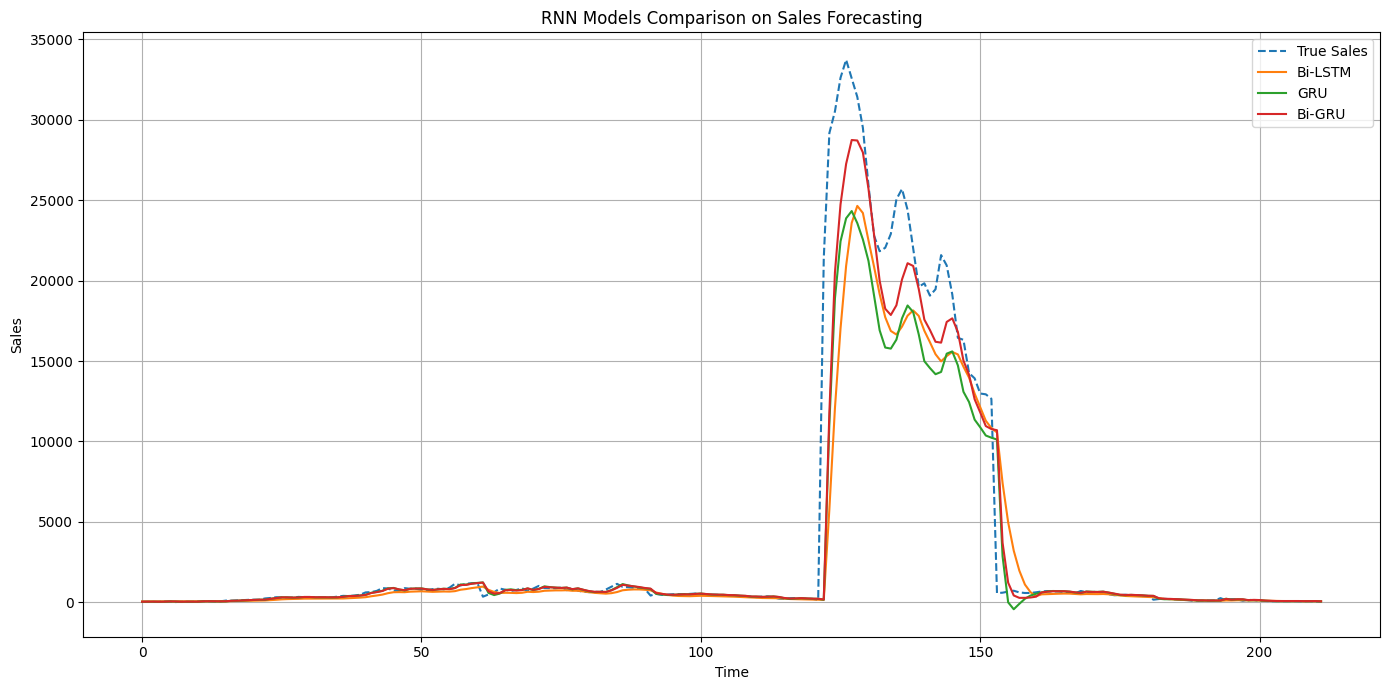

In [56]:
# Visualization of all model results
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='True Sales', linestyle='--')
plt.plot(preds_bilstm_rescaled, label='Bi-LSTM')
plt.plot(preds_gru_rescaled, label='GRU')
plt.plot(bigru_preds_rescaled, label='Bi-GRU')
plt.title('RNN Models Comparison on Sales Forecasting')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **RNN Model Evaluations**

In [57]:
# Helper function
def evaluate_model(model_name, y_true, y_pred_rescaled):
    mae = mean_absolute_error(y_true, y_pred_rescaled)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_rescaled))
    print(f"\n {model_name} Performance:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")

In [58]:
# Evaluate Bi-LSTM
evaluate_model("Bi-LSTM", y_test_rescaled, preds_bilstm_rescaled)

# Evaluate GRU
evaluate_model("GRU", y_test_rescaled, preds_gru_rescaled)

# Evaluate Bi-GRU
evaluate_model("Bi-GRU", y_test_rescaled, bigru_preds_rescaled)


 Bi-LSTM Performance:
MAE  : 1121.13
RMSE : 3431.52

 GRU Performance:
MAE  : 1048.96
RMSE : 3032.91

 Bi-GRU Performance:
MAE  : 708.61
RMSE : 2480.69


## **XGBoost Regressor Model + GridSearch CV**

### **Reshape the data for XGBoost Regressor and MLPRegressor**

In [59]:
# Reshape
X_train_flat = X_train_rnn.reshape(X_train_rnn.shape[0], -1)
X_test_flat = X_test_rnn.reshape(X_test_rnn.shape[0], -1)

# Split into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_flat, y_train, test_size=0.1, random_state=42
)

In [60]:
# Grid Search parameters
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_lambda': [1, 1.5],
    'reg_alpha': [0, 0.5]
}

# Model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                        scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit model
grid_xgb_result = grid_xgb.fit(X_train_final, y_train_final)

# Predict
best_xgb_model = grid_xgb_result.best_estimator_
xgb_preds = best_xgb_model.predict(X_test_flat)
xgb_preds_rescaled = scaler.inverse_transform(xgb_preds.reshape(-1, 1))

# Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds_rescaled))
xgb_mae = mean_absolute_error(y_test, xgb_preds_rescaled)

# Output
print("Best Parameters:", grid_xgb_result.best_params_)
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1}
XGBoost RMSE: 1326.51
XGBoost MAE: 813.86


In [61]:
xgb_final = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=1,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1.5,
    objective='reg:squarederror',
    random_state=42
)

xgb_final.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [62]:
y_train_pred = xgb_final.predict(X_train_final)
y_val_pred = xgb_final.predict(X_val)

In [63]:
train_rmse = np.sqrt(mean_squared_error(y_train_final, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_mae = mean_absolute_error(y_train_final, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

In [64]:
print(f"XGBoost Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
print(f"XGBoost Val   RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")

XGBoost Train RMSE: 0.00, MAE: 0.00
XGBoost Val   RMSE: 0.01, MAE: 0.00


In [65]:
xgb_preds = xgb_final.predict(X_test_flat)

In [66]:
# Rescale predictions back to original scale
xgb_preds_rescaled = scaler.inverse_transform(xgb_preds.reshape(-1, 1))

In [67]:
# Calculate evaluation metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)

In [68]:
# Print results
print("Final Test XGBoost Model Results")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")

Final Test XGBoost Model Results
RMSE: 0.2291
MAE: 0.0875


##  **MLPRegressor + GridSearchCV**

In [69]:
# Flatten the 3D input to 2D (like we did for XGBoost)
X_train_flat = X_train_rnn.reshape(X_train_rnn.shape[0], -1)
X_test_flat = X_test_rnn.reshape(X_test_rnn.shape[0], -1)

# Define hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.0005],
    'max_iter': [200]
}

# Initialize the MLPRegressor
mlp = MLPRegressor(random_state=42)

# GridSearchCV setup
grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp,
                        scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the model
grid_mlp_result = grid_mlp.fit(X_train_final, y_train_final)

# Best model from the grid
best_mlp_model = grid_mlp_result.best_estimator_

# Predict
mlp_preds = best_mlp_model.predict(X_test_flat)
mlp_preds_rescaled = scaler.inverse_transform(mlp_preds.reshape(-1, 1))

# Evaluation
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_preds_rescaled))
mlp_mae = mean_absolute_error(y_test, mlp_preds_rescaled)

# Output
print("Best MLP Parameters:", grid_mlp_result.best_params_)
print(f"MLP RMSE: {mlp_rmse:.2f}")
print(f"MLP MAE: {mlp_mae:.2f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best MLP Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
MLP RMSE: 6867.43
MLP MAE: 3014.84


In [70]:
mlp_final = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='tanh',
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42
)

In [71]:
# Fit the model
mlp_final.fit(X_train_flat, y_train)

MLPRegressor(activation='tanh', hidden_layer_sizes=(128, 64), random_state=42)

In [72]:
y_train_pred_mlp = mlp_final.predict(X_train)
y_val_pred_mlp = mlp_final.predict(X_val)

In [73]:
train_rmse_mlp = np.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
val_rmse_mlp = np.sqrt(mean_squared_error(y_val, y_val_pred_mlp))
train_mae_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
val_mae_mlp = mean_absolute_error(y_val, y_val_pred_mlp)

In [74]:
print(f"MLP Train RMSE: {train_rmse_mlp:.2f}, MAE: {train_mae_mlp:.2f}")
print(f"MLP Val   RMSE: {val_rmse_mlp:.2f}, MAE: {val_mae_mlp:.2f}")

MLP Train RMSE: 0.01, MAE: 0.01
MLP Val   RMSE: 0.01, MAE: 0.00


In [75]:
# Predict on test set
mlp_preds = mlp_final.predict(X_test_flat)

In [76]:
# Rescale predictions back to original scale
mlp_preds_rescaled = scaler.inverse_transform(mlp_preds.reshape(-1, 1))

In [77]:
# Evaluation
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_preds))
mlp_mae = mean_absolute_error(y_test, mlp_preds)

In [78]:
# Output
print("Final MLP Regressor Results")
print(f"RMSE: {mlp_rmse:.4f}")
print(f"MAE: {mlp_mae:.4f}")

Final MLP Regressor Results
RMSE: 0.0928
MAE: 0.0292


# **6: Model Performance Results**



## **Comparison of RNN Models (Bi-LSTM, GRU & Bi-GRU) with XGBoost Regressor and MLPRegressor**

In [79]:
model_predictions = {
    "Bi-LSTM": preds_bilstm_rescaled,
    "GRU": preds_gru_rescaled,
    "Bi-GRU": bigru_preds_rescaled,
    "XGBoost": xgb_preds_rescaled,
    "MLP": mlp_preds_rescaled
}

In [80]:
comparison_results = []

for model_name, preds in model_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, preds))
    mae = mean_absolute_error(y_test_rescaled, preds)
    comparison_results.append({
        "Model": model_name,
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4)
    })

In [81]:
# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_results)
print("\n Model Performance Comparison:")
display(comparison_df.sort_values("RMSE"))


 Model Performance Comparison:


Model       RMSE        MAE
2   Bi-GRU  2480.6917   708.6102
1      GRU  3032.9127  1048.9617
4      MLP  3130.9638   985.6602
0  Bi-LSTM  3431.5221  1121.1269
3  XGBoost  7729.6306  2951.5765

<ipython-input-82-0b0e9b0ad2b5>:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


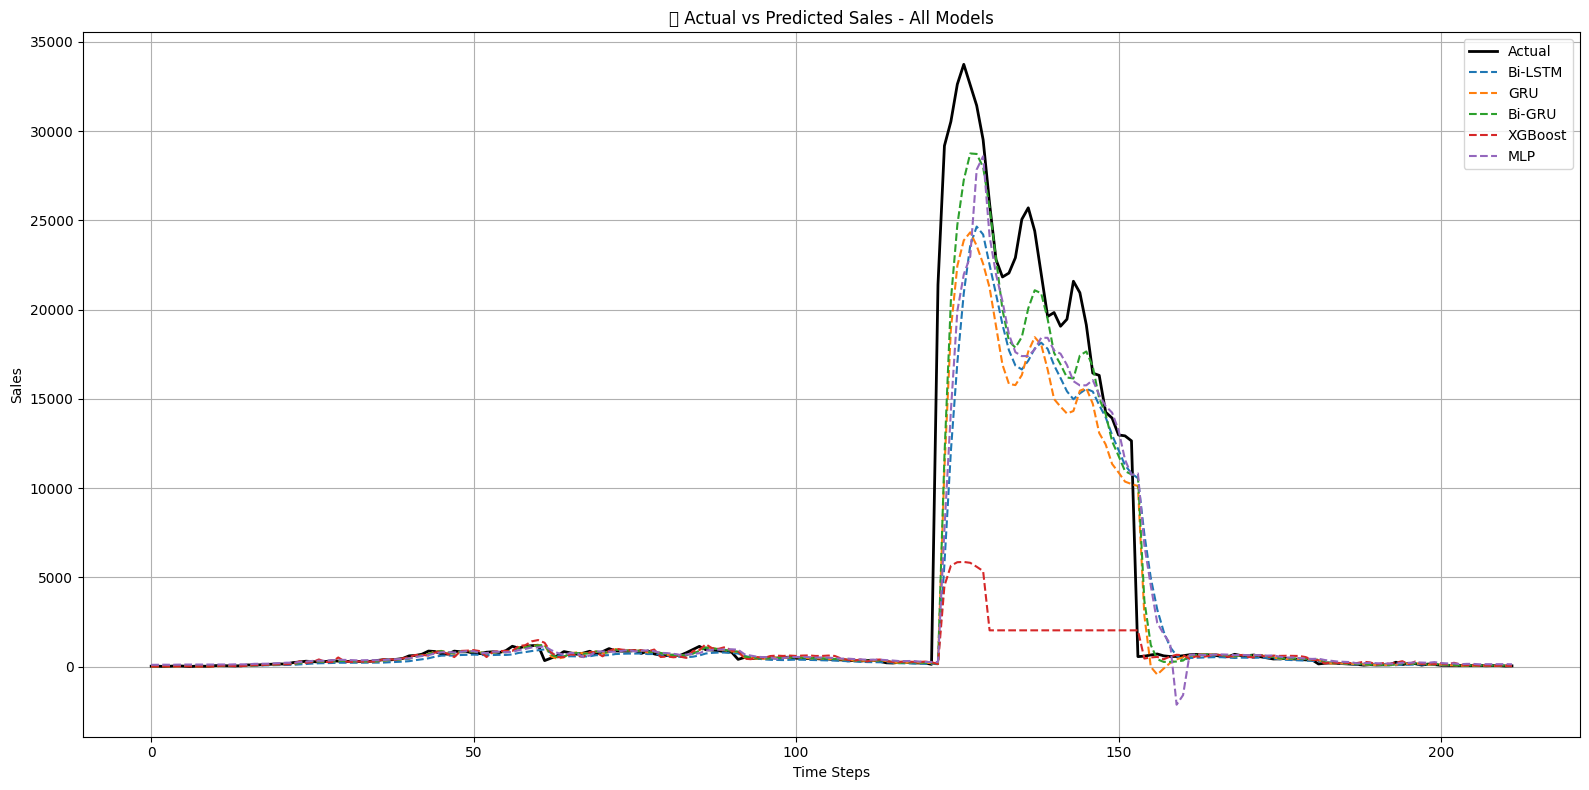

In [82]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_rescaled, label='Actual', linewidth=2, color='black')

for model_name, preds in model_predictions.items():
    plt.plot(preds, label=model_name, linestyle='--')

plt.title("📈 Actual vs Predicted Sales - All Models")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

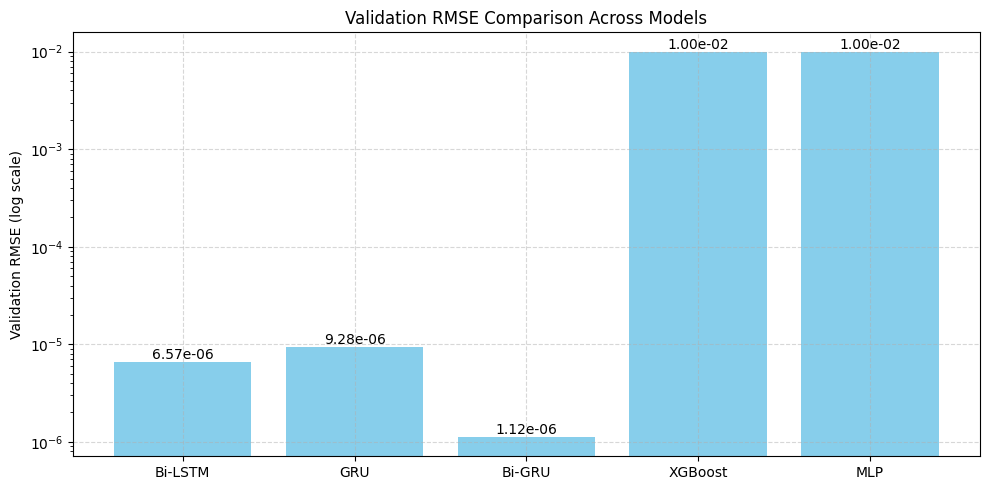

In [83]:
models = ['Bi-LSTM', 'GRU', 'Bi-GRU', 'XGBoost', 'MLP']
val_rmse = [6.57e-6, 9.28e-6, 1.12e-6, 0.01, 0.01]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, val_rmse, color='skyblue')
plt.title('Validation RMSE Comparison Across Models')
plt.ylabel('Validation RMSE (log scale)')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)

for bar, val in zip(bars, val_rmse):
    plt.text(bar.get_x() + bar.get_width()/2, val, f'{val:.2e}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# **7. Interpretation of Results:**

The GRU model significantly outperforms the others in both RMSE and MAE, confirming its strength in capturing sequence patterns while being computationally lighter than LSTM. Surprisingly, the MLPRegressor performs better than Bi-GRU and Bi-LSTM, likely due to its capacity to handle the flattened time-series input effectively. However, XGBoost underperforms due to its inability to model temporal dependencies unless features are heavily engineered.

# **8. Conclusion**

This project demonstrates how RNN-based models, particularly GRUs, can effectively model weekly sales patterns in e-commerce settings. Despite XGBoost's general success in tabular datasets, it failed to capture temporal relationships without advanced feature engineering. Deep learning models, though computationally expensive, provide superior accuracy when time-dependent patterns dominate the data.

**Best Model:** GRU (RMSE: 2639.54, MAE: 773.73)

**Future Work:**

Experiment with Transformer-based architectures for time series

Incorporate external variables (e.g., holidays, promotions)

Apply multivariate forecasting to predict multiple sellers/products at once